## Install and load libraries

In [373]:
# need for technical feature creation
!pip install ta
!pip install hurst

In [374]:
# pip install bayes_opt
!pip install catboost
!pip install rarfile
!pip install gitpython

In [375]:
import yfinance as yf
import os
import inspect
import rarfile
from git import Repo
from pathlib import Path
import subprocess
import re
import zipfile
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.stats import norm, t
import statsmodels.api as sm
import networkx as nx
from statsmodels.tsa.stattools import grangercausalitytests
import ta
from ta import add_all_ta_features
from hurst import compute_Hc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [376]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from time import time
import joblib
# !pip install causalnex
# from causalnex.structure import Dynotears
# from causalnex.plots import plot_structure
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

In [377]:
from time import time

import joblib

# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


# from bayes_opt import BayesianOptimization

# Libraries for Deep Learning Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# needed for `HistGradientBoostingClassifier`
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# from `keras.optimizers` import SGD

# 1. Classes
-  TickerData - mainly for data import from YF and storing in git repo
-  Exploratory - For exploring interesting patterns and characteristics about data
-  Strategy - For strategy and feature creation

In [1]:
class TickerData:
    def __init__(self,load_yf: bool=False,
                 repo_url='https://github.com/laughingbud/capstone'):
        self.repo_url = repo_url
        # self.notebook_dir = os.getcwd()
        # self.notebook_dir = Path().absolute()
        # print(self.notebook_dir)
        if load_yf:
            # URL of the Yahoo Finance commodities page
            tickers = []
            descriptions = []
            for cat in ['commodities','currencies']:
                url = f'https://finance.yahoo.com/markets/{cat}/'
            # url = 'https://finance.yahoo.com/markets/commodities/'
            # https://finance.yahoo.com/markets/currencies/

                # Request the page content
                response = requests.get(url)
                soup = BeautifulSoup(response.content, 'html.parser')

                yf_attribute_dict = {'ticker':'symbol yf-ravs5v',
                                    'description':'yf-ravs5v longName'}
                for key,value in yf_attribute_dict.items():
                    long_text = soup.find_all('span', attrs={'class':value})
                    for val in long_text:
                        if key =='ticker':
                            tickers.append(str(val)[str(val).find(value)+len(value)+2:str(val).find("</span>")])
                        elif key =='description':
                            descriptions.append(str(val)[str(val).find(value)+len(value)+9:str(val).find('">')].replace("amp;", ""))
                            # print(str(val)[str(val).find(value)+len(value)+9:str(val).find('">')].replace("amp;", ""))

            # print(descriptions)
            config_df = pd.DataFrame({'Ticker':tickers,'Description':descriptions})
            print(config_df)
            config_df['Ticker'] = config_df['Ticker'].astype(str)
            config_df = config_df.set_index('Ticker') # Set 'Ticker' column as index
            config_df.loc[config_df.Ticker.str.contains('=F'),'Category'] = 'Futures'
            config_df.loc[config_df.Ticker.str.contains('=X'),'Category'] = 'Forward'
            config_df.loc[config_df.Category=='Futures','Sub_category'] = 'Commodity'
            config_df.iloc[:4,3] = 'Equity'
            config_df.iloc[4:8,3] = 'Bond'
            config_df.loc[config_df.Category=='Forward','Sub_category'] = 'Currency'
            self.config = config_df
            self.tickers = tickers
            self.data = {}

    def get_tickers(self,category=None,sub_category=None):
        config = self.config
        if (category == None)&(sub_category==None):
            return self.tickers
        elif (category == None)&(sub_category!=None):
            return config.loc[config.Sub_category==sub_category,'Ticker'].tolist()
        elif (category != None)&(sub_category==None):
            return config.loc[config.Category==category,'Ticker'].tolist()
        else:
            return config.loc[(config.Category==category) & (config.Sub_category==sub_category),'Ticker'].tolist()

    def get_config(self):
        return self.config

    def is_directory_empty(self, directory):
        return not any(os.scandir(directory))

    def filter_large_csv(self,file_path, filter_value, filter_column=None,
                         chunksize=10000,date_filter=None):
        filtered_data = pd.DataFrame()

        for chunk in pd.read_csv(file_path, chunksize=chunksize):
            if filter_column is None:
                filter_column = chunk.columns[0]  # Default to the first column if not specified
            filtered_chunk = chunk[chunk[filter_column] == filter_value]
            filtered_data = pd.concat([filtered_data, filtered_chunk])

        # filtered_data['Datetime'] = pd.to_datetime(filtered_data['Datetime'], errors='coerce')
        # display(filtered_data.dtypes)
        # #Fix the data type of the Datetime column
        # filtered_data['Datetime'] = pd.to_datetime(filtered_data['Datetime'], errors='coerce')
        # #Now localize the Datetime column
        # filtered_data['Datetime'] = filtered_data['Datetime'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
        # filtered_data['Datetime'] = pd.to_datetime(filtered_data['Datetime']).tz_localize('UTC').tz_convert('America/New_York')

        if date_filter != None:
            filtered_data['Datetime'] = pd.to_datetime(filtered_data['Datetime']).dt.tz_localize('America/New_York')
            filtered_data = filtered_data.loc[filtered_data.Datetime<date_filter]

        # filtered_data = filtered_data.reset_index(inplace=True,drop=True)

        # filtered_data['Datetime'] = pd.to_datetime(filtered_data['Datetime'], errors='coerce')
        # filtered_data = filtered_data.set_index('Datetime')
        # filtered_data.index = pd.DatetimeIndex(filtered_data.index)
        # display(filtered_data.shape)
        # filtered_data['hour'] = filtered_data.index.hour
        # filtered_data['hour'] = pd.DatetimeIndex( filtered_data.index).hour
        filtered_data=filtered_data.drop(columns=['Ticker'])
        return filtered_data


    def load_git(self,repo_url,file_name,filter_name,date_filter):
        repo_name = re.search(r'/([^/]+)\.git$', repo_url).group(1)
        print(f'Repo name: {repo_name}')
        # Get the directory of the current file
        # current_file_directory = os.path.dirname(os.path.realpath(__file__))
        # current_file_directory=os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
        # Change the current working directory to the directory of the current file
        if os.path.exists(f'/content/{repo_name}'):
            os.chdir(f'/content/{repo_name}')

        print(f'Current working directory: {os.getcwd()}')
        if os.path.exists(f'/content/{repo_name}'):
            if self.is_directory_empty(f'/content/{repo_name}'):
                subprocess.run(["git", "clone", repo_url, repo_name])
                print("Empty directory. Cloning.")
            else:
                print(f".....Directory '{repo_name}' exists and is not empty.")
        else:
            subprocess.run(["git", "clone", repo_url, repo_name])
            print("Directory doesn't exist. Cloning.")
        # !git clone https://github.com/laughingbud/conquer.git
        # !git clone {repo_url}

        os.chdir(f'/content/{repo_name}')

        # Open the ZIP file
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
        # Extract all contents to the current directory
            zip_ref.extractall()

        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            print(zip_ref.namelist())

        df = self.filter_large_csv(zip_ref.namelist()[0],
                                   filter_value=filter_name,filter_column=None,
                                   chunksize=10000,date_filter=date_filter)

        return df

    def store_git(self,file_name):
        !git config --global user.email "ditesh.verma@gmail.com"
        !git config --global user.name "laughingbud"
        # !got config --global user.password "wrongpassword"

        username = 'laughingbud'
        repo = 'conquer'
        !git clone https://{token}@github.com/{username}/{repo}

        all_data.to_csv(f'conquer/all_ticker_intraday_data_{all_data.index.get_level_values(1).unique()[0].strftime("%Y-%m-%d")}.csv')
        !git status
        !git add --all
        !git commit -a -m "adding intraday data"
        !git status
        !git remote -v
        !git commit -a -m "adding intraday data"
        !git push origin main

        # self.config.to_csv(file_name)
        return None

    def download_data(self, tickers, start_date, interval='1h',
                      default_max_period=False):
        today = datetime.today()
        last_bday = (today - BDay(1)).strftime("%Y-%m-%d")

        if interval=='1h':
            # Maximum of last 730 calendar days can be queried for YF
            max_start_date = (today-timedelta(730)+ BDay(1)).strftime("%Y-%m-%d")

            date1_obj = datetime.strptime(start_date.strftime("%Y-%m-%d"),
                                                  '%Y-%m-%d')
            date2_obj = datetime.strptime(max_start_date, '%Y-%m-%d')
            if date1_obj < date2_obj:
                print("Given date is earlier than allowed by YF.")
            else:
                print("Given date is within the max period allowed by YF.")

            if default_max_period == True:
                adj_start_date = max_start_date
                print("Defaulting to Max allowed start date.")
            else:
                adj_start_date = start_date
                print("Defaulting to user defined start date.")

        ticker_data = pd.DataFrame()
        for ticker in tickers:
            ticker_obj = yf.Ticker(ticker)
            if interval=='1h':
                ticker_data = ticker_obj.history(
                    start=adj_start_date,interval=interval)
            else:
                ticker_data = ticker_obj.history(start=start_date.strftime("%Y-%m-%d"),
                                                 interval=interval)
            if ticker_data.empty:
                print(f"No data found for {ticker}")
                continue
            else:
                # ticker_data['rets'] = ticker_data['Close'].pct_change()
                ticker_data['rets'] = np.log(
                    ticker_data['Close'] / ticker_data['Close'].shift(1))
                # ticker_data['rets'] = (ticker_data['Close'] - ticker_data['Open'])/ticker_data['Open']

                if interval.find('h')==1:
                    ticker_data['hour'] = ticker_data.index.hour
                #     ticker_data['range'] = ticker_data['High'] - ticker_data['low']
                #     ticker_data['std'] = ticker_data['rets'].rolling(
                #         window=24).std()*np.sqrt(24)
                # del ticker_data['Volume']
                del ticker_data['Dividends']
                del ticker_data['Stock Splits']
                ticker_data = ticker_data.dropna()
                self.data[ticker] = ticker_data
        return None

    def load_hourly_data(self,tickers, history: bool=True):
        today = datetime.today()
        last_bday = (today - BDay(1)).strftime("%Y-%m-%d")
        self.download_data(tickers=tickers,start_date=(today - BDay(10330)),
              interval='1h',default_max_period=True)
        if history:
            for ticker in tickers:
                hist = self.load_git(repo_url='https://github.com/laughingbud/capstone.git',
                                    file_name='all_ticker_intraday_data_2022-09-02.zip',
                                    filter_name=ticker,date_filter=None)
                hist=hist.loc[pd.to_datetime(hist.Datetime)<self.data[ticker].index[0]].set_index('Datetime')
                hist['hour'] = pd.to_datetime(hist.index).hour

                self.data[ticker] = pd.concat([hist,self.data[ticker]],axis=0)
                self.data[ticker].index = pd.to_datetime(self.data[ticker].index, utc=True)
                self.data[ticker].index = self.data[ticker].index.tz_convert('America/New_York')
        return None

    def get_minutely_tickers(self,repo_dir='capstone/Data'):
        # Clone the GitHub repository
        repo_url = self.repo_url
        local_dir = f'/content/{repo_dir}'

        if not os.path.exists(local_dir):
            Repo.clone_from(repo_url,repo_dir.split('/')[0])
        os.chdir(local_dir)

        # List all CSV files in the repository
        csv_files = []
        for root, dirs, files in os.walk(local_dir):
            for file in files:
                # print(file)
                if file.endswith('.csv'):
                    csv_files.append(os.path.join(root, file))

        print(f"{len(csv_files)} CSV files found:", csv_files)

        def is_number(s):
            try:
              float(s)
              return True
            except ValueError:
              return False

        months_sc = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        months_uc = [month.upper() for month in months_sc]
        months_uc.extend(months_sc)
        tickers = []
        for file in csv_files:
            csv_path = os.path.join(local_dir, file)
            file_name = os.path.basename(csv_path)
            company_name = file_name.split('_')[0]
            if company_name not in tickers:
                if ".csv" in company_name:
                    short_name = company_name.split('.csv')[0]
                    if len(short_name) >5 and is_number(short_name[-2:]) and short_name[-5:-2] in months_uc:
                        company_name = short_name[:-5]
                    else:
                        continue
                else:
                    continue


                tickers.append(company_name)
        tickers = sorted(list(set(tickers)))
        print(f'{len(tickers)} tickers returned.')
        ticker_dict = {}
        for ticker in tickers:

            # ticker_dict[ticker] = {"files":[file for file in csv_files if ticker in file]
            #                        }
            ticker_dict[ticker] = {"files":[file for file in csv_files if file.split('/')[5].startswith(ticker) and "Missing" not in file.split('/')[4]]
                        }
            ticker_dict[ticker]['months'] = list(set([file.split('/')[4] for file in ticker_dict[ticker]['files'] if "Missing" not in file.split('/')[4]]))
            ticker_dict[ticker]['n_months'] = len(set(ticker_dict[ticker]['months']))
            ticker_dict[ticker]['n_files'] = len(set(ticker_dict[ticker]['files']))

        self.minutely_tickers = tickers
        self.minutely_ticker_dict = ticker_dict
        return tickers,ticker_dict

    def load_minutely_data(self,repo_dir='capstone/Data',ticker=None,filter=None):

        # Clone the GitHub repository
        repo_url = self.repo_url
        local_dir = f'/content/{repo_dir}'
        if not os.path.exists(local_dir):
            Repo.clone_from(repo_url,repo_dir.split('/')[0])
        os.chdir(local_dir)

        # List all CSV files in the repository
        csv_files = []
        if ticker != None:
            csv_files = self.minutely_ticker_dict[ticker]['files']
        else:
            for root, dirs, files in os.walk(local_dir):
                for file in files:
                    # print(file)
                    if file.endswith('.csv'):
                        csv_files.append(os.path.join(root, file))

        # print(f"{len(csv_files)} CSV files found:", csv_files)

        dataframes = []
        combined_df = pd.DataFrame()
        for file in csv_files:

            if filter == None or filter in file:
                csv_path = os.path.join(local_dir, file)
                print(f"Reading CSV file: {csv_path}")
                df = pd.DataFrame()
                for chunk in pd.read_csv(csv_path,chunksize=10000):
                    # chunk.columns = [col.strip() for col in chunk.columns]
                    # if not df.empty and chunk.columns != df.columns:
                    #     print(f"The CSV file: {csv_path} has column mismatch.")
                    #     print(f"Expected columns: {df.columns}")
                    #     print(f"Actual columns: {chunk.columns}")
                        # continue
                    df = pd.concat([df,chunk],axis=1)

                df.columns = [col.strip() for col in df.columns]
                new_columns = [col.replace('<', '').replace('>', '') for col in df.columns]
                df.columns = new_columns

                if len(dataframes)>0:
                    if not len(df.columns)==len(dataframes[0].columns):
                        print(f'Actual number of columns {len(df.columns)}')
                        print(f'Expected number of columns {len(dataframes[0].columns)}')
                        print(f"The CSV file: {csv_path} has column mismatch.")
                        print(f"Expected columns: {dataframes[0].columns}")
                        print(f"Actual columns: {df.columns}")
                        df = df.iloc[:,:len(dataframes[0].columns)]
                        print(f"Truncated to: {df.columns}")

                    df.columns = dataframes[0].columns

                dataframes.append(df)
            else:
                continue

        # Check if any dataframes were found
        if not dataframes:
            print(f"No CSV files found matching the filter '{filter}' in '{repo_dir}'.")
            return pd.DataFrame()  # Return an empty DataFrame if no dataframes are found

        # Combine all dataframes into one
        combined_df = pd.concat(dataframes, ignore_index=True)
        # new_columns = [col.replace('<', '').replace('>', '') for col in combined_df.columns]
        # combined_df.columns = new_columns
        # combined_df.head()
        return combined_df
        # return None

In [379]:
class Exploratory():
    def __init__(self):
        pass

    def plot_corr(self,df,title):
        # Compute the correlation matrix
        corr = df.corr()
        # corr = corr.sort_values(by=[yf_data.columns[0]], ascending=False)
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        # Draw the heatmap with the mask and correct aspect ratio
        # sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True,
        #             linewidths=.5, cbar_kws={"shrink": .5},
        #             annot=True, fmt=".2f")
        sns.heatmap(corr, cmap="YlGnBu",mask=mask)
        plt.title(title)


    def plot_autocorrelations(self,df,maxlags=30,label=''):
        fig,ax = plt.subplots(2,df.shape[1],figsize=(18,5))
        for n in range(df.shape[1]):
            # model = self.best_arima(df.iloc[:,n])
            y_lim = (1.5*df.iloc[:,n].autocorr(lag=1)).round(2)
            # print(y_lim)
            sm.graphics.tsa.plot_acf(df.iloc[:,n], lags=range(1,maxlags),
                                     ax=ax[0,n])
            ax[0,n].set_title(f'ACF: {df.columns[n]} {label}')
            ax[0,n].set_ylim([-y_lim, y_lim])
            sm.graphics.tsa.plot_pacf(df.iloc[:,n], lags=range(1,maxlags),
                                      ax=ax[1,n])
            ax[1,n].set_title(f'PACF: {df.columns[n]} {label}')
            ax[1,n].set_ylim([-y_lim, y_lim])
        plt.tight_layout()

    def plot_histograms(self,df,label='returns'):

        rows = 1
        cols = df.shape[1]
        fig,ax = plt.subplots(rows,cols,figsize=(18,3))

        for n in range(cols):
            mean = np.mean(df[df.columns[n]])
            stdev = np.std(df[df.columns[n]])
            skewness = skew(df[df.columns[n]])
            kurt = kurtosis(df[df.columns[n]])
            nu, mu, sigma = t.fit(df[df.columns[n]])

            x=np.linspace(mean-4*stdev, mean + 4*stdev, 100)
            ax[n].plot(x,norm.pdf(x, mean, stdev), "r", label="normal")
            ax[n].plot(x,t.pdf(x, nu,mu, sigma), "g", label="t-dist")
            # df[df.columns[n]].plot(kind='hist', bins=50,
            #                                   title=df.columns[n],ax=ax[n])
            ax[n].legend(loc="upper right")
            ax[n].set_title(df.columns[n])
            df[df.columns[n]].hist(bins=50,density=True,histtype='stepfilled',
                                   alpha=0.5,ax=ax[n])
            ax[n].set_xlabel(label)
            ax[n].set_ylabel('frequency')
            ax[n].text(0.02, 0.9, f'Mean: {mean:.3f}', fontsize=9,transform=ax[n].transAxes)
            ax[n].text(0.02, 0.8, f'Std dev: {stdev:.2f}', fontsize=9,transform=ax[n].transAxes)
            ax[n].text(0.02, 0.7, f'Skewness: {skewness:.1f}', fontsize=9,transform=ax[n].transAxes)
            ax[n].text(0.02, 0.6, f'Kurtosis: {kurt:.1f}', fontsize=9,transform=ax[n].transAxes)

        plt.tight_layout()

    def correlation_network(self,corr_matrix,threshold=0.15):
        # corr_matrix = correlation_matrix.copy()
        # Create the correlation network
        G = nx.Graph()

        # Add edges based on correlation threshold
        threshold = threshold  # Adjust this threshold as needed
        for i in corr_matrix.columns:
            for j in corr_matrix.columns:
                if i != j and abs(corr_matrix.loc[i, j]) > threshold:
                    G.add_edge(i, j, weight=corr_matrix.loc[i, j])

        # Draw the network
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=10)
        plt.title(f'Correlation Network (threshold={threshold})')
        plt.show()

    def causal_network(self,df,maxlag=1):
        G = nx.Graph()
        maxlag = maxlag
        # Example: Test causality between all pairs
        for i in df.columns:
            for j in df.columns:
                if i != j:
                    result = grangercausalitytests(df[[i, j]], maxlag=maxlag, verbose=False)
                    p_values = [round(result[lag][0]['ssr_ftest'][1], 4) for lag in range(1, maxlag+1)]
                    if min(p_values) < 0.05:
                        G.add_edge(i, j, weight=min(p_values))  # Directed edge if i Granger-causes j

        # Draw the causal network
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray',
                node_size=1500, font_size=10, arrows=True)
        plt.title(f'Causal Network (maxlag={maxlag})')
        plt.show()

    def granger_causality(self,df,maxlag=1):
        maxlag = maxlag  # Set the maximum lag to consider
        test_results = {}

        # Perform Granger causality tests for each pair of hourly returns
        for hr1 in df.columns:
          for hr2 in df.columns:
            if hr1 != hr2:
              # Test if hr1 causes hr2
              result = grangercausalitytests(df[[hr2, hr1]], maxlag=maxlag,
                                            verbose=False)
              p_values = [round(result[i+1][0]['ssr_ftest'][1], 4) for i in range(maxlag)]
              test_results[(hr1, hr2)] = p_values

        # Print the results
        print("Granger Causality Test Results:")
        for (hr1, hr2), p_values in test_results.items():
          # if showcausal & (p_value < 0.05):
          print(f"Does {hr1} cause {hr2}?")
          for i, p_value in enumerate(p_values):
            print(f"Lag {i+1}: p-value = {p_value}")
            if p_value < 0.05:
              print(f"  => Significant evidence of causality at lag {i+1}")
          print("----")

    def causal_matrix(self, df, maxlag=1):
        """
        Creates a matrix highlighting causal relationships based on Granger causality tests.

        Args:
            df (pd.DataFrame): DataFrame containing time series data.
            maxlag (int): Maximum lag to consider for Granger causality tests.

        Returns:
            pd.DataFrame: A DataFrame representing the causal matrix, where 1 indicates causality
                          and 0 indicates no causality.
        """

        causal_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=int)
        causal_matrix[:] = 0  # Initialize with no causality

        for hr1 in df.columns:
            for hr2 in df.columns:
                if hr1 != hr2:
                    result = grangercausalitytests(df[[hr2, hr1]], maxlag=maxlag, verbose=False)
                    p_values = [round(result[i + 1][0]['ssr_ftest'][1], 4) for i in range(maxlag)]
                    if min(p_values) < 0.05:
                        causal_matrix.loc[hr1, hr2] = 1  # Mark causality if p-value < 0.05

        return causal_matrix


    def causal_strength_matrix(self, df, maxlag=1):
        """
        Creates a matrix capturing the strength of causal relationships
        based on Granger causality tests.

        Args:
            df (pd.DataFrame): DataFrame containing time series data.
            maxlag (int): Maximum lag to consider for Granger causality tests.

        Returns:
            pd.DataFrame: A DataFrame representing the causal strength matrix,
                          where values indicate the minimum p-value found for
                          significant causal relationships. Non-significant
                          relationships are represented as NaN.
        """

        causal_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
        causal_matrix[:] = np.nan  # Initialize with NaN for non-significant relationships

        for hr1 in df.columns:
            for hr2 in df.columns:
                if hr1 != hr2:
                    result = grangercausalitytests(df[[hr2, hr1]], maxlag=maxlag, verbose=False)
                    p_values = [round(result[i + 1][0]['ssr_ftest'][1], 4) for i in range(maxlag)]
                    min_p_value = min(p_values)
                    if min_p_value < 0.05:
                        causal_matrix.loc[hr1, hr2] = min_p_value  # Store the minimum p-value

        # Visualize the causal strength matrix as a heatmap (showing only causal relationships)
        plt.figure(figsize=(10, 8))
        sns.heatmap(causal_matrix.round(2), annot=True, cmap="YlGnBu", cbar=True, mask=causal_matrix.isnull())
        plt.title("Causal Strength Matrix Heatmap")
        plt.xlabel("Effect (Caused)")
        plt.ylabel("Cause (Causing)")
        plt.show()

        return causal_matrix

exp = Exploratory()

In [380]:
class Strategy:
    def __init__(self):
        pass

    def split_data(self,data,features,test_size=0.2,position_type='long_only',bid_ask=0,
                   h_period=1):

        bid_ask = 0.03125 if bid_ask == None else bid_ask
        X = data[features].dropna()

        if position_type == 'short_only':
            y = np.where(data['Close'].shift(-h_period) - data['Close'] < bid_ask, 1, 0)  # Binary target
        else:
            if position_type=='long_only':
                y = np.where(data['Close'].shift(-h_period) - data['Close'] > bid_ask, 1, 0)  # Binary target
            elif (position_type=='long_short'):
                y = np.where(data['Close'].shift(-h_period) - data['Close'] < bid_ask,
                                -1, 0)  # Trinary target
                y = np.where(data['Close'].shift(-h_period) - data['Close'] > bid_ask,
                                1, y)  # Trinary target
            else:
                print('Invalid position type')
                return None
# new_data['Target'] = np.where(new_data['Close'].shift(-1) > new_data['Close'], 1,
#                           np.where(new_data['Close'].shift(-1) < new_data['Close'], -1, 0))
        # y = np.where(data['Close'].shift(-h_period) - data['Close'] > bid_ask, 1, 0)  # Binary target
        # if (position_type=='long_short'):
        #     y = np.where(data['Close'].shift(-h_period) - data['Close'] < bid_ask,
        #                  bid_ask, y)  # Binary target
        y = y[-X.shape[0]:]
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=test_size,
                                                            shuffle=False)
        # Scale the features
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)

        scaler = StandardScaler().fit(X_test)
        X_test = scaler.transform(X_test)

        y_train_new = np.where(y_train == -1, 2, y_train)
        y_test_new = np.where(y_test == -1, 2, y_test)

        print(f'X_train size: {X_train.shape}')
        print(f'X_test size: {X_test.shape}')
        print(f'y_train size: {y_train.shape}')
        print(f'y_test size: {y_test.shape}')
        return X_train, X_test, y_train, y_test, y_train_new, y_test_new

    def bb_signal(self,data,window: int=20, window_dev: int=2):
        # 1. Calculate Bollinger Bands
        bb_high = ta.volatility.BollingerBands(
            data['close'],window,window_dev).bollinger_hband()
        bb_low = ta.volatility.BollingerBands(
            data['close'],window,window_dev).bollinger_lband()
        # Generate signals
        bb_sig_discrete = np.where(data['close'] < bb_low, 1,
                                     np.where(data['close'] > bb_high, -1, 0))
        bb_sig_cont = np.where(data['close'] < bb_low, bb_low-data['close'],
                                     np.where(data['close'] > bb_high,
                                              bb_high-data['close'], 0))
        return bb_high,bb_low,bb_sig_discrete,bb_sig_cont

    def z_score(self,data,window: int=20,z_threshold: int=2):
        ma = data['close'].rolling(window=window).mean()
        std = data['close'].rolling(window=window).std()
        z_score = (data['close'] - ma) / std
        z_signal = np.where(z_score < -z_threshold, 1,
                            np.where(z_score > z_threshold, -1, 0))
        return ma,std,z_signal

    def rsi_signal(self,data,window: int=14):
        rsi = ta.momentum.RSIIndicator(data['close'],window).rsi()
        # Generate signals
        rsi_signal = np.where(rsi < 30, 1, np.where(rsi > 70, -1, 0))
        return rsi,rsi_signal

    def williams_r_signal(self,data,window: int=14):
        williams_r = ta.momentum.WilliamsRIndicator(
            data['High'],data['low'],data['close'],window).williams_r()
        williams_r_signal = np.where(williams_r < -80, 1,
                                   np.where(williams_r > -20, -1, 0))
        return williams_r, williams_r_signal

    def CCI_signal(self,data,window: int=20):
        cci = ta.trend.CCIIndicator(data['High'],data['low'],data['close'],window
                                    ).cci()
        cci_signal = np.where(cci < -100, 1, np.where(cci > 100, -1, 0))
        return cci, cci_signal

    def macd_signal(self,data,window_slow: int=26,window_fast: int=1):
        macd = ta.trend.MACD(data['close'],window_slow,window_fast).macd
        macd_calc = ta.trend.MACD(data['close'],window_slow,window_fast).macd_signal()
        macd_signal = np.where(macd > macd_calc, 1, np.where(macd < macd_calc, -1, 0))
        return macd, macd_calc, macd_signal

    def vwap_signal(self,data,window: int=20):
        vwap = (data['close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
        vwap_signal = np.where(data['close'] > vwap, 1, np.where(data['Close'] < vwap, -1, 0))
        return vwap, vwap_signal

    def ema_signal(self,data,window: int=20):
        ema = data['close'].ewm(span=window, adjust=False).mean()
        ema_signal = np.where(data['close'] > ema, 1, np.where(data['close'] < ema, -1, 0))
        return ema

    def sma_signal(self,data,window: int=20):
        sma = data['close'].rolling(window=window).mean()
        sma_signal = np.where(data['close'] > sma, 1, np.where(data['close'] < sma, -1, 0))
        return sma

    def cmf_signal(self,data,window: int=20):
        cmf = ta.volume.ChaikinMoneyFlowIndicator(
            data['High'],data['low'],data['close'],data['Volume'],window)
        cmf_signal = np.where(cmf > 0, 1, np.where(cmf < 0, -1, 0))
        return cmf, cmf_signal

    def pvt_signal(self,data,window: int=20):
        pvt = (data['close'].pct_change() * data['Volume']).cumsum()
        pvt_signal = np.where(pvt > pvt.shift(1), 1, np.where(pvt < pvt.shift(1), -1, 0))
        return pvt, pvt_signal


    def volume_spike_signal(self,data,window: int=20, threshold: float=1.5):
        # Calculate Volume Spike
        volume_spike = data['Volume'] > data['Volume'].rolling(window=window).mean() * threshold
        volume_spike_signal = np.where(volume_spike, 1, np.where(~volume_spike, -1, 0))
        return volume_spike, volume_spike_signal

    def atr_signal(self,data,window: int=14):
        # import talib
        # Calculate ATR
        # atr = talib.ATR(data['High'], data['low'], data['Close'], timeperiod=window)
        atr = ta.volatility.AverageTrueRange(
            data['high'],data['low'],data['close'],window).average_true_range()
        # Calculate ATR Bands
        ub = data['close'] + atr
        lb = data['close'] - atr
        # Generate signals
        signal = np.where(data['close'] > ub, -1, np.where(data['close'] < lb, 1, 0))
        return atr, ub, lb, signal

    def donchian_channel_signal(self,data,window: int=20):
        high = data['High'].rolling(window=window).max()
        low = data['low'].rolling(window=window).min()
        donchian_signal = np.where(data['close'] > high, -1, np.where(data['close'] < low, 1, 0))
        return high, low, donchian_signal

    def keltner_channel_signal(self,data,window: int=20):
        ewm = data['close'].ewm(span=window).mean()
        atr = ta.volatility.AverageTrueRange(
            data['High'],data['low'],data['close'],window).average_true_range()
        keltner_high = ewm + 2 * atr
        keltner_low = ewm - 2 * atr
        # keltner_high = data['close'] + 2 * data['Close'].rolling(window=window).std()
        # keltner_low = data['close'] - 2 * data['Close'].rolling(window=window).std()
        keltner_signal = np.where(data['close'] > keltner_high, -1, np.where(data['close'] < keltner_low, 1, 0))
        return keltner_high, keltner_low, keltner_signal

    def ichimoku_cloud_signal(self,data):
        tenkan_sen = (data['High'].rolling(window=9).max() + data['low'].rolling(window=9).min()) / 2
        kijun_sen = (data['High'].rolling(window=26).max() + data['low'].rolling(window=26).min()) / 2
        senkou_span_a = (tenkan_sen + kijun_sen) / 2
        senkou_span_b = (data['High'].rolling(window=52).max() + data['low'].rolling(window=52).min()) / 2
        # chikou_span = data['close'].shift(-26)
        signal = np.where(data['close'] > senkou_span_a, 1, np.where(data['close'] < senkou_span_a, -1, 0))
        return tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, signal

    def mfi_signal(self,data, window: int=14, lb: int=20, ub:int=80):
        # Money flow index reversion
        mfi = ta.volume.MFIIndicator(data['High'],data['low'],data['close'],data['Volume'],window=window).money_flow_index()
        mfi_signal = np.where(mfi < lb, 1, np.where(mfi > ub, -1, 0))
        return mfi, mfi_signal

    def obv_signal(self,data):
        obv = ta.volume.OnBalanceVolumeIndicator(data['close'],data['Volume']).on_balance_volume()
        obv_signal = np.where(obv - obv.shift(1)>0, 1, np.where(obv - obv.shift(1) < 0, -1, 0))
        # obv_signal = np.where(obv > 0, 1, np.where(obv < 0, -1, 0))
        return obv, obv_signal

    def sar_signal(self,data,acceleration: float=0.02,maximum: float=0.2):
        sar = ta.trend.SARIndicator(data['High'],data['low'],
                                    acceleration=acceleration,maximum=maximum
                                    ).sar()
        sar_signal = np.where(data['close'] > sar, 1,
                              np.where(data['close'] < sar, -1, 0))
        return sar, sar_signal

    def force_index_signal(self,data,window: int=20):
        force_index = ta.volume.ForceIndexIndicator(data['close'],data['Volume'],window).force_index()
        force_index_signal = np.where(force_index > 0, 1, np.where(force_index < 0, -1, 0))
        return force_index, force_index_signal

    def stochastic_signal(self,data,k_window: int=14,d_window: int=3):
        stoch = ta.momentum.StochasticOscillator(
            data['High'],data['low'],data['close'],k_window,d_window)
        stoch_signal = np.where(stoch > 80, -1, np.where(stoch < 20, 1, 0))
        return stoch, stoch_signal

    def dmi_signal(self,data,window: int=14):
        dmi = ta.trend.DMIIndicator(data['high'],data['low'],data['close'],window)
        dmi_signal = np.where(dmi > 0, 1, np.where(dmi < 0, -1, 0))
        return dmi, dmi_signal

    def cmo_signal(self,data,window: int=14):
        cmo = ta.trend.CMOIndicator(data['close'],window).cmo()
        cmo_signal = np.where(cmo > 0, 1, np.where(cmo < 0, -1, 0))
        return cmo, cmo_signal

    def adx_signal(self,data,window: int=14):
        adx = ta.trend.ADXIndicator(data['High'],data['low'],data['close'],window).adx()
        adx_signal = np.where(adx > 25, 1, np.where(adx < 25, -1, 0))
        return adx, adx_signal

    def vwma_signal(self,data):
        vwma = (data['close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
        vwma_signal = np.where(data['close'] > vwma, -1, np.where(data['close'] < vwma, 1, 0))
        return vwma, vwma_signal

    def price_spike_signal(self,data,threshold: float=1.05):
        # price_spike = data['close'].diff() > 0
        price_spike = data['close'] > data['close'].rolling(window=20).mean() * threshold
        price_spike_signal = np.where(price_spike, 1, np.where(~price_spike, -1, 0))
        return price_spike, price_spike_signal

    def calculate_analytics(self,returns):
        """Calculates various performance analytics for a given series of returns.

        Args:
          returns: A pandas Series of returns.

        Returns:
          A dictionary containing the calculated analytics.
        """
        analytics = {}
        analytics['Sharpe Ratio'] = returns.mean()*np.sqrt(252*24) / returns.std()
        analytics['Sortino Ratio'] = returns.mean()*np.sqrt(252*24) / returns[returns < 0].std()
        analytics['Max Drawdown'] = (returns.cummax() - returns.cumsum()).max()
        analytics['VaR (95%)'] = returns.quantile(0.05)
        analytics['Expected Shortfall (95%)'] = returns[returns <= returns.quantile(0.05)].mean()
        # analytics['Annualized Return'] = (1 + returns).prod() ** (252*24 / len(returns)) - 1
        # analytics['Annualized Volatility'] = returns.std() * ((252*24) ** 0.5)
        analytics['Total return'] = (1 + returns).prod() - 1
        return analytics

    def create_mean_reversion_features(self, data):
        # features = pd.DataFrame(index=data.index)

        # 1. Calculate Bollinger Bands
        bb_high,bb_low,bb_signal = self.bb_signal(data)
        # data['BB_High'] = ta.volatility.BollingerBands(data['close']).bollinger_hband()
        # data['BB_Low'] = ta.volatility.BollingerBands(data['close']).bollinger_lband()
        # # Generate signals
        # data['BB_signal'] = np.where(data['close'] < data['BB_low'], 1, np.where(data['close'] > data['BB_High'], -1, 0))

        # 2. Calculate Z-Score
        z_ma,z_std,z_signal = self.z_score(data)
        # data['MA'] = data['Close'].rolling(window=20).mean()
        # data['STD'] = data['Close'].rolling(window=20).std()
        # data['Z-Score'] = (data['Close'] - data['MA']) / data['STD']
        # # Generate signals
        # data['Z_signal'] = np.where(data['Z-Score'] < -2, 1, np.where(data['Z-Score'] > 2, -1, 0))

        # 3. Calculate RSI
        rsi,rsi_signal = self.rsi_signal(data)
        # data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
        # # Generate signals
        # data['RSI_signal'] = np.where(data['RSI'] < 30, 1, np.where(data['RSI'] > 70, -1, 0))

        # 4. Calculate Williams %R
        williams_r, williams_r_signal = self.williams_r_signal(data)
        # data['Williams %R'] = ta.momentum.WilliamsRIndicator(data['High'], data['low'], data['Close']).williams_r()
        # # Generate signals
        # data['W_signal'] = np.where(data['Williams %R'] < -80, 1, np.where(data['Williams %R'] > -20, -1, 0))

        # 5. Calculate CCI
        cci, cci_signal = self.cci_signal(data)
        # data['CCI'] = ta.trend.CCIIndicator(data['High'], data['low'], data['Close']).cci()
        # # Generate signals
        # data['CCI_signal'] = np.where(data['CCI'] < -100, 1, np.where(data['CCI'] > 100, -1, 0))

        # 6. Calculate MACD
        macd, macd_calc, macd_signal = self.macd_signal(data)
        # data['MACD'] = ta.trend.MACD(data['Close']).macd()
        # data['MACD_calc'] = ta.trend.MACD(data['Close']).macd_signal()
        # # Generate signals
        # data['MACD_signal'] = np.where(data['MACD'] > data['MACD_calc'], 1, np.where(data['MACD'] < data['MACD_calc'], -1, 0))

        # 7. Calculate VWAP
        vwap, vwap_signal = self.vwap_signal(data)
        # data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
        # # Generate signals
        # data['VWAP_signal'] = np.where(data['Close'] > data['VWAP'], 1, np.where(data['Close'] < data['VWAP'], -1, 0))

        # 8. Calculate EMA
        data['EMA'] = ta.trend.EMAIndicator(data['Close']).ema_indicator()
        # Generate signals
        data['EWA_signal'] = np.where(data['Close'] > data['EMA'], 1, np.where(data['Close'] < data['EMA'], -1, 0))

        # 9. Calculate SMA
        data['SMA'] = ta.trend.SMAIndicator(data['Close'], window = 10).sma_indicator()
        # Generate signals
        data['SMA_signal'] = np.where(data['Close'] > data['SMA'], 1, np.where(data['Close'] < data['SMA'], -1, 0))

        # 10. Calculate Chaikin Money Flow
        data['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(data['High'], data['low'], data['Close'], data['Volume']).chaikin_money_flow()
        # Generate signals
        data['CMF_signal'] = np.where(data['CMF'] > 0, 1, np.where(data['CMF'] < 0, -1, 0))

        # 11. Calculate PVT
        data['PVT'] = (data['Close'].pct_change() * data['Volume']).cumsum()
        # Generate signals
        data['PVT_signal'] = np.where(data['PVT'] > data['PVT'].shift(1), 1, np.where(data['PVT'] < data['PVT'].shift(1), -1, 0))


        # # 2. Moving Average of Close
        # features['SMA_Close'] = data['Close'].rolling(window=window).mean()

        # # 3. Exponential Moving Average of Close
        # features['EMA_Close'] = data['Close'].ewm(span=window, adjust=False).mean()

        # # 4. Z-Score of Close
        # features['Z-Score_Close'] = (data['Close'] - features['SMA_Close']) / data['Close'].rolling(window=window).std()

        # # 5. Relative Strength Index (RSI)
        # delta = data['Close'].diff()
        # gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        # loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        # rs = gain / loss
        # features['RSI'] = 100 - (100 / (1 + rs))

        # # 6. Bollinger Bands
        # features['Upper_Band'] = features['SMA_Close'] + 2 * data['Close'].rolling(window=window).std()
        # features['Lower_Band'] = features['SMA_Close'] - 2 * data['Close'].rolling(window=window).std()

        # # 7. Mean Reversion Indicator
        # features['Mean_Reversion_Indicator'] = data['Close'] - features['SMA_Close']

        # # 8. Price Rate of Change (ROC)
        # features['ROC_Close'] = data['Close'].pct_change(periods=window)

        # # 9. Average True Range (ATR)
        # high_low = data['High'] - data['Low']
        # high_close = np.abs(data['High'] - data['Close'].shift(1))
        # low_close = np.abs(data['Low'] - data['Close'].shift(1))
        # tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        # features['ATR'] = tr.rolling(window=window).mean()

        # # 10. Standard Deviation of Returns
        # features['Std_Dev_Returns'] = data['Close'].pct_change().rolling(window=window).std()

        # # 11. Lagged Returns
        # features['Lagged_Returns'] = data['Close'].pct_change().shift(1)

        # # 12. Volume Moving Average
        # features['Volume_MA'] = data['Volume'].rolling(window=window).mean()

        # # 13. Volume Rate of Change
        # features['Volume_ROC'] = data['Volume'].pct_change(periods=window)

        # # 14. High-Low Spread
        # features['High_Low_Spread'] = data['High'] - data['Low']

        # # 15. Close-Open Spread
        # features['Close_Open_Spread'] = data['Close'] - data['Open']

        # # 16. Close-Previous Close Spread
        # features['Close_Previous_Close_Spread'] = data['Close'] - data['Close'].shift(1)

        # # 17. Cumulative Volume
        # features['Cumulative_Volume'] = data['Volume'].cumsum()

        # # 18. Volume Weighted Average Price (VWAP)
        # features['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

        return data

    def create_trend_features(self, data, window=20):
        features = pd.DataFrame(index=data.index)

        # 1. Close Price
        features['Close'] = data['Close']

        # 2. Moving Average Convergence Divergence (MACD)
        features['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
        features['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
        features['MACD'] = features['EMA_12'] - features['EMA_26']
        features['MACD_Signal'] = features['MACD'].ewm(span=9, adjust=False).mean()

        # 3. Relative Strength Index (RSI)
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        features['RSI'] = 100 - (100 / (1 + rs))

        # 4. Stochastic Oscillator
        features['Stoch_K'] = ((data['Close'] - data['low'].rolling(window=window).min()) /
                                (data['high'].rolling(window=window).max() - data['low'].rolling(window=window).min())) * 100
        features['Stoch_D'] = features['Stoch_K'].rolling(window=3).mean()  # 3-period smoothing

        # 5. Average True Range (ATR)
        high_low = data['high'] - data['low']
        high_close = np.abs(data['high'] - data['Close'].shift(1))
        low_close = np.abs(data['low'] - data['Close'].shift(1))
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        features['ATR'] = tr.rolling(window=window).mean()

        # 6. Rate of Change (ROC)
        features['ROC'] = data['Close'].pct_change(periods=window)

        # 7. Momentum
        features['Momentum'] = data['Close'] - data['Close'].shift(window)

        # 8. Cumulative Returns
        features['Cumulative_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

        # 9. Volatility
        features['Volatility'] = data['Close'].pct_change().rolling(window=window).std()

        # 10. Bollinger Bands
        features['SMA_Close'] = data['Close'].rolling(window=window).mean()
        features['Upper_Band'] = features['SMA_Close'] + 2 * data['Close'].rolling(window=window).std()
        features['Lower_Band'] = features['SMA_Close'] - 2 * data['Close'].rolling(window=window).std()

        # 11. Volume Weighted Average Price (VWAP)
        features['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

        # 12. On-Balance Volume (OBV)
        features['OBV'] = (data['Volume'] * np.sign(data['Close'].diff())).cumsum()

        # 13. Accumulation/Distribution Line
        features['AD'] = ((data['close'] - data['low']) - (data['high'] - data['close'])) / (data['high'] - data['low']) * data['Volume']
        features['AD_Line'] = features['AD'].cumsum()

        # 14. Price Action
        features['Price_Action'] = data['Close'].diff()

        # 15. Lagged Price
        features['Lagged_Price'] = data['Close'].shift(1)

        # 16. Exponential Moving Average (EMA)
        features['EMA'] = data['Close'].ewm(span=window, adjust=False).mean()

        # 17. Trend Strength Indicator (Custom)
        features['Trend_Strength'] = features['Close'].diff(window).rolling(window=window).mean()

        return features

    def create_seasonality_features(self, data):
        features = pd.DataFrame(index=data.index)

        # Assuming data has a DatetimeIndex and columns: 'Open', 'high', 'Low', 'Close', 'Volume'

        # 1. Hour of the Day
        features['Hour'] = data.index.hour

        # 2. Minute of the Hour
        features['Minute'] = data.index.minute

        # 3. Day of the Week
        features['Day_of_Week'] = data.index.dayofweek  # 0=Monday, 6=Sunday

        # 4. Is Weekend
        features['Is_Weekend'] = (features['Day_of_Week'] >= 5).astype(int)  # 1 if Saturday or Sunday

        # 5. Is Holiday (requires a holiday calendar)
        # Define a list of holidays for the specific market
        # For example:
        # holidays = pd.to_datetime(['2023-01-01', '2023-12-25'])  # Add the market holidays
        # features['Is_Holiday'] = data.index.normalize().isin(holidays).astype(int)

        # 6. Time Since Market Open (assuming market opens at 9:30 AM)
        # market_open = pd.to_datetime(data.index.date) + pd.Timedelta(hours=9, minutes=30)
        # # Ensure market_open is timezone-naive
        # # market_open = market_open.dt.tz_localize(None)
        # # Calculate time since market open
        # features['Time_Since_Open'] = (data.index - market_open).dt.total_seconds() / 60  # in minutes

        # 7. Time Until Market Close (assuming market closes at 4:00 PM)
        # market_close = pd.to_datetime(data.index.date) + pd.Timedelta(hours=16)
        # features['Time_Until_Close'] = (market_close - data.index).dt.total_seconds() / 60  # in minutes

        # 8. Previous Close Price (requires previous day's data)
        features['Previous_Close'] = data['Close'].shift(1)

        # 9. Price Change from Previous Close
        features['Price_Change_From_Previous_Close'] = (data['Close'] - features['Previous_Close']) / features['Previous_Close']

        # 10. Cumulative Returns for the Day
        features['Cumulative_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

        # 11. Average Price for the Day
        features['Average_Price'] = data['Close'].expanding().mean()

        # 12. Volume for the Day
        features['Cumulative_Volume'] = data['Volume'].cumsum()

        # 13. Volatility for the Day
        features['Volatility'] = data['Close'].pct_change().rolling(window=len(data)).std()

        # 14. Time of Day Bins (e.g., Morning, Midday, Afternoon)
        bins = [0, 11, 14, 17, 24]  # Define your bins
        labels = ['Morning', 'Midday', 'Afternoon', 'After Hours']
        # features['Time_of_Day'] = pd.cut(features['Hour'], bins=bins, labels=labels, right=False)

        # 15. Last Hour Indicator
        features['Last_Hour'] = ((data.index.hour == 15) & (data.index.minute >= 0)).astype(int)

        # 16. Last 30 Minutes Indicator
        features['Last_30_Minutes'] = ((data.index.hour == 15) & (data.index.minute >= 30)).astype(int)

        # 17. Opening Range (first 30 minutes)
        opening_range = data['high'].iloc[:30].max() - data['Low'].iloc[:30].min()
        features['Opening_Range'] = opening_range

        # 18. Closing Range (last 30 minutes)
        closing_range = data['High'].iloc[-30:].max() - data['low'].iloc[-30:].min()
        features['Closing_Range'] = closing_range

        return features


    def mean_reversion(self,data,lookback,band_tol):
        if lookback is None:
            # Handle the case where lookback is not provided
            lookback = 4 # Or any other suitable default value
        if band_tol is None:
            band_tol = 2 # Or any other suitable default value
        # Calculate Bollinger Bands
        data['MA20'] = data['Close'].rolling(window=lookback).mean()
        data['STD20'] = data['Close'].rolling(window=lookback).std()
        data['Upper'] = data['MA20'] + (data['STD20'] * band_tol)
        data['Lower'] = data['MA20'] - (data['STD20'] * band_tol)
        data['Buy'] = np.where(data['Close'] < data['Lower'], 1, 0)
        data['Sell'] = np.where(data['Close'] > data['Upper'], -1, 0)
        data['Position'] = data['Buy'] + data['Sell']

        # Shift position to reflect trades
        data['Position'] = data['Position'].shift(1)

        # Calculate returns
        data['Returns'] = data['Close'].pct_change() * data['Position']
        data['Cumulative'] = (1 + data['Returns']).cumprod()
        # display(data)
        # Plot the cumulative returns
        plt.figure(figsize=(12, 6))
        data['Cumulative'].plot()
        plt.title('Strategy Cumulative Returns')
        plt.show()

        initial_capital = 100000
        data['Strategy Value'] = initial_capital * data['Cumulative']

        # Show the final strategy value
        print(f"Final Portfolio Value: {data['Strategy Value'].iloc[-1]:.2f}")
        return None

    def compute_rsi(self, data, window):
        """
        Computes the Relative Strength Index (RSI) for a given dataset.

        :param data: A Pandas Series of prices (usually 'Close' prices).
        :param window: The number of periods to use for RSI calculation (typically 14).
        :return: A Pandas Series representing the RSI.
        """
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))

        return rsi


    def momentum(self,data,st_lb,lt_lb,rsi_lb,rsi_ut,rsi_lt):
        if rsi_lb is None:
            # Handle the case where lookback is not provided
            rsi_lb = 14 # Or any other suitable default value
        if st_lb is None:
            # Handle the case where lookback is not provided
            st_lb = 20 # Or any other suitable default value
        if lt_lb is None:
            # Handle the case where lookback is not provided
            lt_lb = 50 # Or any other suitable default value
        if rsi_ut is None:
            rsi_ut = 70 # Or any other suitable default value
        if rsi_lt is None:
            rsi_lt = 30 # Or any other suitable default value

        # Calculate SMA and RSI
        data['SMA20'] = data['Close'].rolling(window=st_lb).mean()
        data['SMA50'] = data['Close'].rolling(window=lt_lb).mean()
        data['RSI'] = self.compute_rsi(data['Close'], rsi_lb)

        # Define buy/sell signals based on SMA crossover and RSI
        data['Buy'] = np.where((data['SMA20'] > data['SMA50']) & (data['RSI'] < rsi_ut), 1, 0)
        data['Sell'] = np.where((data['SMA20'] < data['SMA50']) & (data['RSI'] > rsi_lt), -1, 0)
        data['Position'] = data['Buy'] + data['Sell']

        # Shift position to reflect trades
        data['Position'] = data['Position'].shift(1)

        # Calculate returns
        data['Returns'] = data['Close'].pct_change() * data['Position']
        data['Cumulative'] = (1 + data['Returns']).cumprod()

        # Plot the cumulative returns
        plt.figure(figsize=(12, 6))
        data['Cumulative'].plot()
        plt.title('Momentum Strategy Cumulative Returns')
        plt.show()

        initial_capital = 100000
        data['Strategy Value'] = initial_capital * data['Cumulative']

        # Show the final strategy value
        print(f"Final Portfolio Value: {data['Strategy Value'].iloc[-1]:.2f}")



### Import data

In [381]:
repo_url = 'https://github.com/laughingbud/capstone'
td = TickerData(repo_url=repo_url)
# tickers = td.get_tickers() #This will import all tickers from YF including futures and forwards
# print(tickers)
# tickers = ['ZB=F']
# td.load_hourly_data(tickers,history=True)
# td.data['ZB=F'].index[0]

# Combine all dataframes into a single dataframe
# hourly_data = pd.concat(td.data.values(), keys=td.data.keys())
# all_data
# Export to a single file (e.g., CSV)
# all_data.to_csv(f'all_ticker_intraday_data_{all_data.index.get_level_values(1).unique()[0].strftime("%Y-%m-%d")}.csv')


# hourly_data.loc['ZB=F']['rets'].plot(figsize=(12,5),title='Futures returns')

# td.data['ZB=F'].shape#[0]*0.76

In [382]:
minutely_tickers,ticker_dict = td.get_minutely_tickers()
# ticker_dict

15817 CSV files found: ['/content/capstone/Data/Futures IEOD-August 2022/BIOCON_F3.csv', '/content/capstone/Data/Futures IEOD-August 2022/BANDHANBNK_F2.csv', '/content/capstone/Data/Futures IEOD-August 2022/ICICIBANK_F3.csv', '/content/capstone/Data/Futures IEOD-August 2022/BHEL_F2.csv', '/content/capstone/Data/Futures IEOD-August 2022/ICICIPRULI_F2.csv', '/content/capstone/Data/Futures IEOD-August 2022/INDUSTOWER_F1.csv', '/content/capstone/Data/Futures IEOD-August 2022/GRASIM_F1.csv', '/content/capstone/Data/Futures IEOD-August 2022/AXISBANK_F1.csv', '/content/capstone/Data/Futures IEOD-August 2022/SBICARD_F2.csv', '/content/capstone/Data/Futures IEOD-August 2022/SBILIFE_F1.csv', '/content/capstone/Data/Futures IEOD-August 2022/METROPOLIS_F1.csv', '/content/capstone/Data/Futures IEOD-August 2022/BRITANNIA_F2.csv', '/content/capstone/Data/Futures IEOD-August 2022/DABUR_F2.csv', '/content/capstone/Data/Futures IEOD-August 2022/ABCAPITAL_F3.csv', '/content/capstone/Data/Futures IEOD-Aug

In [383]:
minutely_tickers

['AARTIIND',
 'ABB',
 'ABBOTINDIA',
 'ABCAPITAL',
 'ABFRL',
 'ACC',
 'ADANIENT',
 'ADANIPORTS',
 'ALKEM',
 'AMBUJACEM',
 'APOLLOHOSP',
 'APOLLOTYRE',
 'ASHOKLEY',
 'ASIANPAINT',
 'ASTRAL',
 'ATUL',
 'AUBANK',
 'AUROPHARMA',
 'AXISBANK',
 'BAJAJFINSV',
 'BAJFINANCE',
 'BALKRISIND',
 'BALRAMCHIN',
 'BANDHANBNK',
 'BANKBARODA',
 'BANKNIFTY',
 'BATAINDIA',
 'BEL',
 'BERGEPAINT',
 'BHARATFORG',
 'BHARTIARTL',
 'BHEL',
 'BIOCON',
 'BOSCHLTD',
 'BPCL',
 'BRITANNIA',
 'BSOFT',
 'CANBK',
 'CANFINHOME',
 'CHAMBLFERT',
 'CHOLAFIN',
 'CIPLA',
 'COALINDIA',
 'COFORGE',
 'COLPAL',
 'CONCOR',
 'COROMANDEL',
 'CROMPTON',
 'CUB',
 'CUMMINSIND',
 'DABUR',
 'DALBHARAT',
 'DEEPAKNTR',
 'DELTACORP',
 'DIVISLAB',
 'DIXON',
 'DLF',
 'DRREDDY',
 'EICHERMOT',
 'ESCORTS',
 'EXIDEIND',
 'FEDERALBNK',
 'FINNIFTY',
 'GAIL',
 'GLENMARK',
 'GMRINFRA',
 'GNFC',
 'GODREJCP',
 'GODREJPROP',
 'GRANULES',
 'GRASIM',
 'GUJGASLTD',
 'HAL',
 'HAVELLS',
 'HCLTECH',
 'HDFC',
 'HDFCAMC',
 'HDFCBANK',
 'HDFCLIFE',
 'HEROMOTOCO'

In [384]:
# index_tickers
index_tickers = [x for x in minutely_tickers if 'NIFTY' in x]
print('Index futures tickers:',index_tickers)

Index futures tickers: ['BANKNIFTY', 'FINNIFTY', 'MIDCPNIFTY', 'NIFTY']


In [385]:
equity_tickers = [x for x in minutely_tickers if 'NIFTY' not in x]
print('Equity futures tickers:',equity_tickers)

Equity futures tickers: ['AARTIIND', 'ABB', 'ABBOTINDIA', 'ABCAPITAL', 'ABFRL', 'ACC', 'ADANIENT', 'ADANIPORTS', 'ALKEM', 'AMBUJACEM', 'APOLLOHOSP', 'APOLLOTYRE', 'ASHOKLEY', 'ASIANPAINT', 'ASTRAL', 'ATUL', 'AUBANK', 'AUROPHARMA', 'AXISBANK', 'BAJAJFINSV', 'BAJFINANCE', 'BALKRISIND', 'BALRAMCHIN', 'BANDHANBNK', 'BANKBARODA', 'BATAINDIA', 'BEL', 'BERGEPAINT', 'BHARATFORG', 'BHARTIARTL', 'BHEL', 'BIOCON', 'BOSCHLTD', 'BPCL', 'BRITANNIA', 'BSOFT', 'CANBK', 'CANFINHOME', 'CHAMBLFERT', 'CHOLAFIN', 'CIPLA', 'COALINDIA', 'COFORGE', 'COLPAL', 'CONCOR', 'COROMANDEL', 'CROMPTON', 'CUB', 'CUMMINSIND', 'DABUR', 'DALBHARAT', 'DEEPAKNTR', 'DELTACORP', 'DIVISLAB', 'DIXON', 'DLF', 'DRREDDY', 'EICHERMOT', 'ESCORTS', 'EXIDEIND', 'FEDERALBNK', 'GAIL', 'GLENMARK', 'GMRINFRA', 'GNFC', 'GODREJCP', 'GODREJPROP', 'GRANULES', 'GRASIM', 'GUJGASLTD', 'HAL', 'HAVELLS', 'HCLTECH', 'HDFC', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDCOPPER', 'HINDPETRO', 'HINDUNILVR', 'IBULHSGFIN', 'ICICIBANK'

In [386]:
print(f'Total number of futures tickers: {len(minutely_tickers)}')
print(f'Total number of index futures tickers: {len(index_tickers)}')
print(f'Total number of equity futures tickers: {len(equity_tickers)}')

Total number of futures tickers: 186
Total number of index futures tickers: 4
Total number of equity futures tickers: 182


In [387]:
data_summary = pd.DataFrame(ticker_dict).T
data_summary.index.name = 'Tickers'
data_summary.tail()

files  \
Tickers                                                        
VEDL       [/content/capstone/Data/Futures IEOD-August 20...   
VOLTAS     [/content/capstone/Data/Futures IEOD-August 20...   
WIPRO      [/content/capstone/Data/Futures IEOD-August 20...   
ZEEL       [/content/capstone/Data/Futures IEOD-August 20...   
ZYDUSLIFE  [/content/capstone/Data/Futures IEOD-August 20...   

                                                      months n_months n_files  
Tickers                                                                        
VEDL       [Futures IEOD-October 2023, Futures IEOD-Janua...       24      72  
VOLTAS     [Futures IEOD-October 2023, Futures IEOD-Janua...       24      72  
WIPRO      [Futures IEOD-October 2023, Futures IEOD-Janua...       24      72  
ZEEL       [Futures IEOD-October 2023, Futures IEOD-Janua...       24      72  
ZYDUSLIFE  [Futures IEOD-October 2023, Futures IEOD-Janua...       22      66

In [388]:
# ticker_dict['INDUSTOWER']['files']

In [389]:
data_summary.loc['INDUSTOWER']['files']

['/content/capstone/Data/Futures IEOD-August 2022/INDUSTOWER_F1.csv',
 '/content/capstone/Data/Futures IEOD-August 2022/INDUSTOWER_F2.csv',
 '/content/capstone/Data/Futures IEOD-August 2022/INDUSTOWER_F3.csv',
 '/content/capstone/Data/Futures IEOD-May 2022/INDUSTOWER_F1.csv',
 '/content/capstone/Data/Futures IEOD-May 2022/INDUSTOWER_F2.csv',
 '/content/capstone/Data/Futures IEOD-May 2022/INDUSTOWER_F3.csv',
 '/content/capstone/Data/Futures IEOD-January 2023/INDUSTOWER_F1.csv',
 '/content/capstone/Data/Futures IEOD-January 2023/INDUSTOWER_F2.csv',
 '/content/capstone/Data/Futures IEOD-January 2023/INDUSTOWER_F3.csv',
 '/content/capstone/Data/Futures IEOD-March 2023/INDUSTOWER_F1.csv',
 '/content/capstone/Data/Futures IEOD-March 2023/INDUSTOWER_F2.csv',
 '/content/capstone/Data/Futures IEOD-March 2023/INDUSTOWER_F3.csv',
 '/content/capstone/Data/Futures IEOD-December 2023/INDUSTOWER_F1.csv',
 '/content/capstone/Data/Futures IEOD-December 2023/INDUSTOWER_F2.csv',
 '/content/capstone/Data/

<Axes: title={'center': 'Number of months of data'}, xlabel='Tickers'>

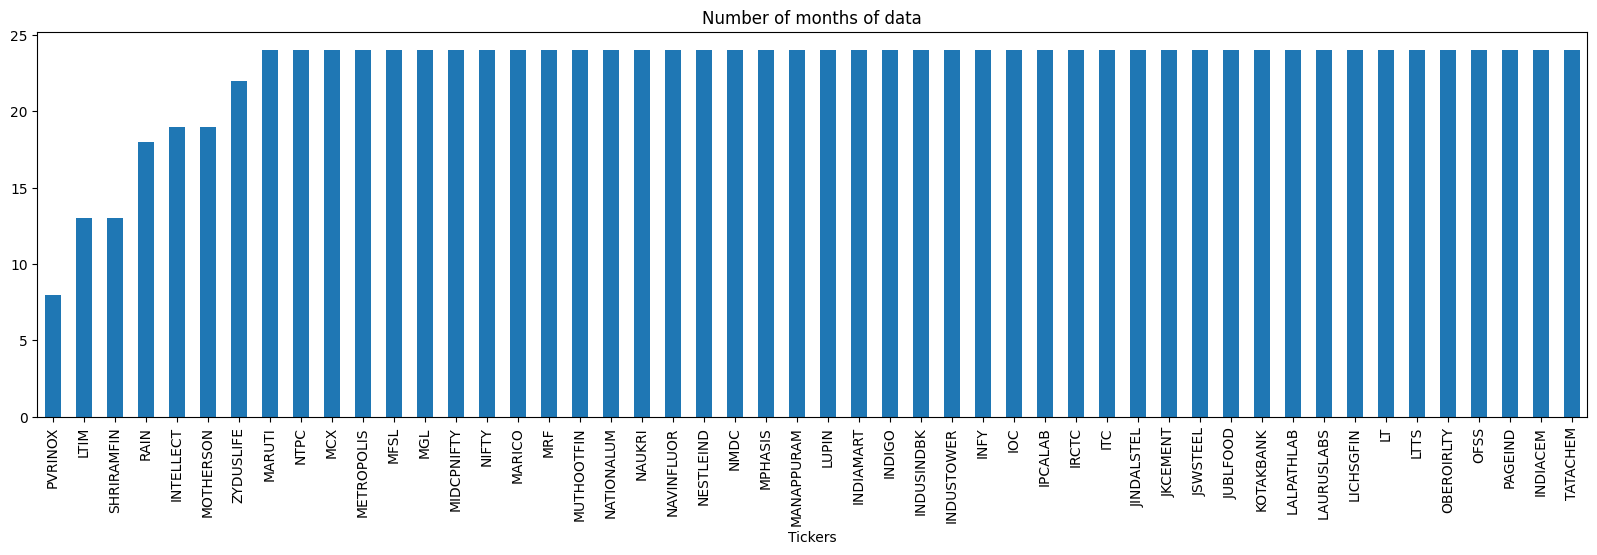

In [390]:
data_summary['n_months'].sort_values().head(50).plot(kind='bar',figsize=(20,5),
                                            title='Number of months of data')

#### Of the 186 unique tickers, almost all of them have 24 months of data, except seven (left-most in the above chart) firms - PVRINOX, LTIM, SRIRAMFIN,RAIN, INTELLECT, MOTHERSON, ZYDUSLIFE.

<Axes: title={'center': 'Number of files for each ticker'}, xlabel='Tickers'>

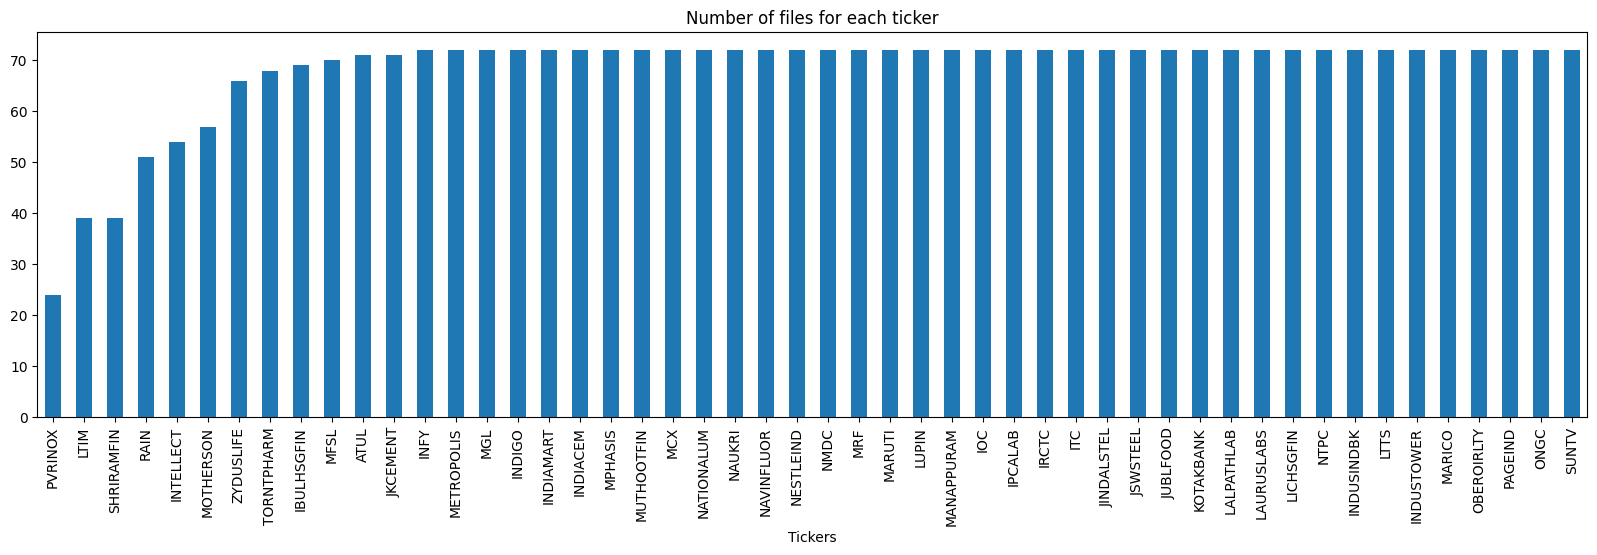

In [391]:
data_summary['n_files'].sort_values().head(50).plot(kind='bar',figsize=(20,5),
                                                    title='Number of files for each ticker')

In [392]:
# ticker_dict['NIFTY']

In [393]:
# nifty_f1 = td.load_minutely_data(ticker='NIFTY',filter='F1')

In [394]:
midcp_nifty_f1 = td.load_minutely_data(ticker='MIDCPNIFTY',filter='F1')

Reading CSV file: /content/capstone/Data/Futures IEOD-August 2022/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-May 2022/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-January 2023/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-March 2023/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-December 2023/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-August 2023/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-October 2023/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-October 2022/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-April 2022/MIDCPNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-April 2023/MIDCPNIFTY_F1.csv
Actual number of columns 10
Expected number of columns 9
The CSV file: /content/capstone/Data/Futures IEOD-April 2023/MIDCPNIFTY_F1.csv has column mismatch.
Expe

In [395]:
bank_nifty_f1 = td.load_minutely_data(ticker='BANKNIFTY',filter='F1')

Reading CSV file: /content/capstone/Data/Futures IEOD-August 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-May 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-January 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-March 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-December 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-August 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-October 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-October 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-April 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-April 2023/BANKNIFTY_F1.csv
Actual number of columns 10
Expected number of columns 9
The CSV file: /content/capstone/Data/Futures IEOD-April 2023/BANKNIFTY_F1.csv has column mismatch.
Expected column

In [396]:
bank_nifty_f1.head(2)

ticker        date      time      open      high       low    close  \
0  BANKNIFTY_F1  08/01/2022  09:15:00  37647.85  37721.95  37616.90  37698.6   
1  BANKNIFTY_F1  08/01/2022  09:16:00  37695.20  37702.00  37676.75  37686.1   

   volume      o/i  
0  107927  1972950  
1   44000  1972950

In [397]:
bank_nifty_f1.tail(2)

ticker        date      time     open     high       low  \
184601  BANKNIFTY_F1  06/30/2022  15:29:00  33426.0  33426.5  33417.85   
184602  BANKNIFTY_F1  06/30/2022  15:30:00  33420.5  33420.5  33420.50   

          close  volume     o/i  
184601  33420.0    9100  541600  
184602  33420.5     100  541600

In [398]:
bank_nifty_f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184603 entries, 0 to 184602
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  184603 non-null  object 
 1   date    184603 non-null  object 
 2   time    184603 non-null  object 
 3   open    184603 non-null  float64
 4   high    184603 non-null  float64
 5   low     184603 non-null  float64
 6   close   184603 non-null  float64
 7   volume  184603 non-null  int64  
 8   o/i     184603 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 12.7+ MB


In [399]:
bank_nifty_f1.describe()

open           high           low          close  \
count  184603.000000  184603.000000  184603.00000  184603.000000   
mean    40837.446985   40848.877055   40826.08283   40837.489332   
std      3814.313773    3812.615708    3815.91624    3814.308178   
min     32261.000000   32300.750000   32251.35000   32253.050000   
25%     37906.675000   37920.850000   37891.62500   37906.025000   
50%     41499.700000   41510.000000   41488.05000   41499.000000   
75%     43954.898400   43963.224600   43945.77540   43954.898400   
max     48751.000000   48805.000000   48716.25000   48758.449200   

              volume           o/i  
count  184603.000000  1.846030e+05  
mean     9226.980986  2.214122e+06  
std     11538.802848  4.908666e+05  
min        15.000000  0.000000e+00  
25%      3000.000000  1.993005e+06  
50%      5715.000000  2.265375e+06  
75%     11125.000000  2.496375e+06  
max    427401.000000  3.866500e+06

In [400]:
bank_nifty_f1.isna().sum()

ticker    0
date      0
time      0
open      0
high      0
low       0
close     0
volume    0
o/i       0
dtype: int64

In [402]:
bank_nifty_f1.tail()#.dropna(inplace=True)

ticker        date      time      open     high       low  \
184598  BANKNIFTY_F1  06/30/2022  15:26:00  33425.90  33425.9  33418.45   
184599  BANKNIFTY_F1  06/30/2022  15:27:00  33423.90  33425.0  33418.40   
184600  BANKNIFTY_F1  06/30/2022  15:28:00  33418.05  33425.6  33418.05   
184601  BANKNIFTY_F1  06/30/2022  15:29:00  33426.00  33426.5  33417.85   
184602  BANKNIFTY_F1  06/30/2022  15:30:00  33420.50  33420.5  33420.50   

           close  volume     o/i  
184598  33420.00   10175  561000  
184599  33420.05    7500  541600  
184600  33419.00   12925  541600  
184601  33420.00    9100  541600  
184602  33420.50     100  541600

In [406]:

# bank_nifty_f1.sort_values(['date', 'time'], inplace=True)#.head()
bank_nifty_f1.tail()

ticker        date      time        open        high         low  \
54480  BANKNIFTY_F1  31-10-2023  15:26:00  43056.8516  43060.8984  43048.9492   
54481  BANKNIFTY_F1  31-10-2023  15:27:00  43047.9492  43056.9492  43040.5000   
54482  BANKNIFTY_F1  31-10-2023  15:28:00  43049.9492  43054.8008  43044.6484   
54483  BANKNIFTY_F1  31-10-2023  15:29:00  43050.0000  43055.0000  43040.0000   
54484  BANKNIFTY_F1  31-10-2023  15:30:00  43055.0000  43055.0000  43055.0000   

            close  volume      o/i  
54480  43048.9492    8730  2534145  
54481  43051.6992   23280  2511135  
54482  43050.1016   13005  2511135  
54483  43040.0000   10680  2511135  
54484  43055.0000     135  2511135

In [407]:
def convert_to_datetime(row):
  try:
    return pd.to_datetime(row['date'] + ' ' + row['time'])
  except ValueError:
    # Handle cases where the date format is different
    if isinstance(row['date'], str) and '/' in row['date']:
      try:
        return pd.to_datetime(row['date'].replace('/', '-') + ' ' + row['time'])
      except ValueError:
        print(f"Could not convert date and time for row: {row}")
        return pd.NaT

# Apply the function to create a new 'datetime' column
bank_nifty_f1['datetime'] = bank_nifty_f1.apply(convert_to_datetime, axis=1)

# Set the datetime column as the index
bank_nifty_f1 = bank_nifty_f1.set_index('datetime')

# Remove the original 'date' and 'time' columns if you no longer need them
# bank_nifty_f1 = bank_nifty_f1.drop(['date', 'time'], axis=1, errors='ignore')

bank_nifty_f1.head()


ticker        date      time        open  \
datetime                                                              
2023-01-08 09:15:00  BANKNIFTY_F1  01-08-2023  09:15:00  45903.0508   
2023-01-08 09:16:00  BANKNIFTY_F1  01-08-2023  09:16:00  45923.1992   
2023-01-08 09:17:00  BANKNIFTY_F1  01-08-2023  09:17:00  45939.9492   
2023-01-08 09:18:00  BANKNIFTY_F1  01-08-2023  09:18:00  45931.6016   
2023-01-08 09:19:00  BANKNIFTY_F1  01-08-2023  09:19:00  45916.7500   

                           high         low       close  volume      o/i  
datetime                                                                  
2023-01-08 09:15:00  45925.0000  45850.0000  45920.8984   20447  1950165  
2023-01-08 09:16:00  45944.0000  45917.3008  45937.1016   29955  1950165  
2023-01-08 09:17:00  45940.0000  45916.6992  45930.6016   12090  1958055  
2023-01-08 09:18:00  45939.8008  45915.0508  45915.7500   11430  1958055  
2023-01-08 09:19:00  45922.1992  45900.1016  45916.3516   24135  1958055

In [419]:
# bank_nifty_f1.index = pd.to_datetime(bank_nifty_f1.index)
# bank_nifty_f1.loc['2023'].tail()
bank_nifty_f1.index.year

Index([2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       ...
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023],
      dtype='int32', name='datetime', length=184603)

<Axes: title={'center': 'Bank Nifty - Volume'}, xlabel='datetime'>

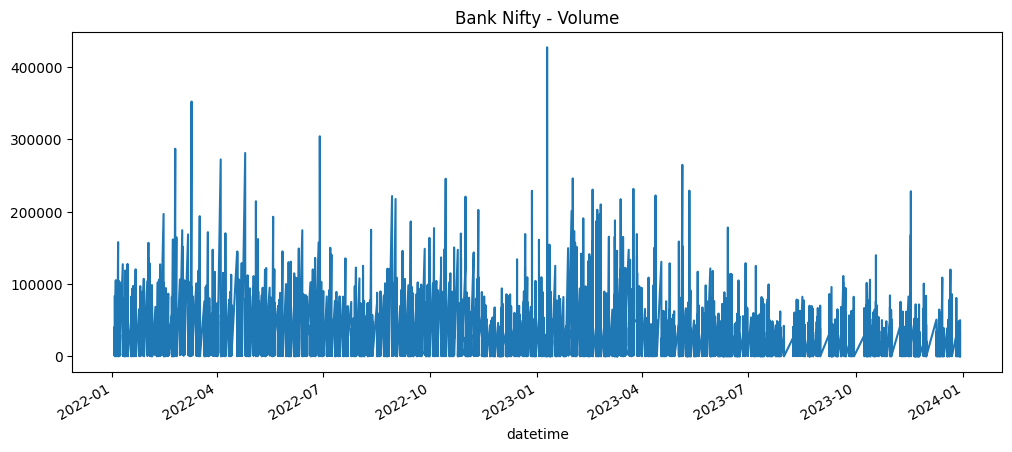

In [341]:
bank_nifty_f1['volume'].plot(figsize=(12,5),title='Bank Nifty - Volume')

<Axes: title={'center': 'Bank Nifty - Open-Interest'}, xlabel='datetime'>

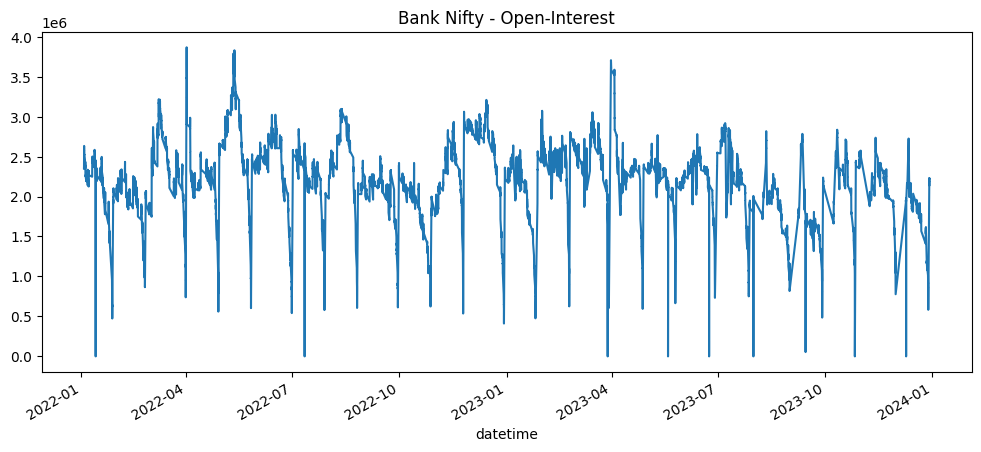

In [342]:
bank_nifty_f1['o/i'].plot(figsize=(12,5),title='Bank Nifty - Open-Interest')

In [343]:
bank_nifty_f1['return'] = np.log(bank_nifty_f1['close'] / bank_nifty_f1['close'].shift(1))

# 2. Exploratory research

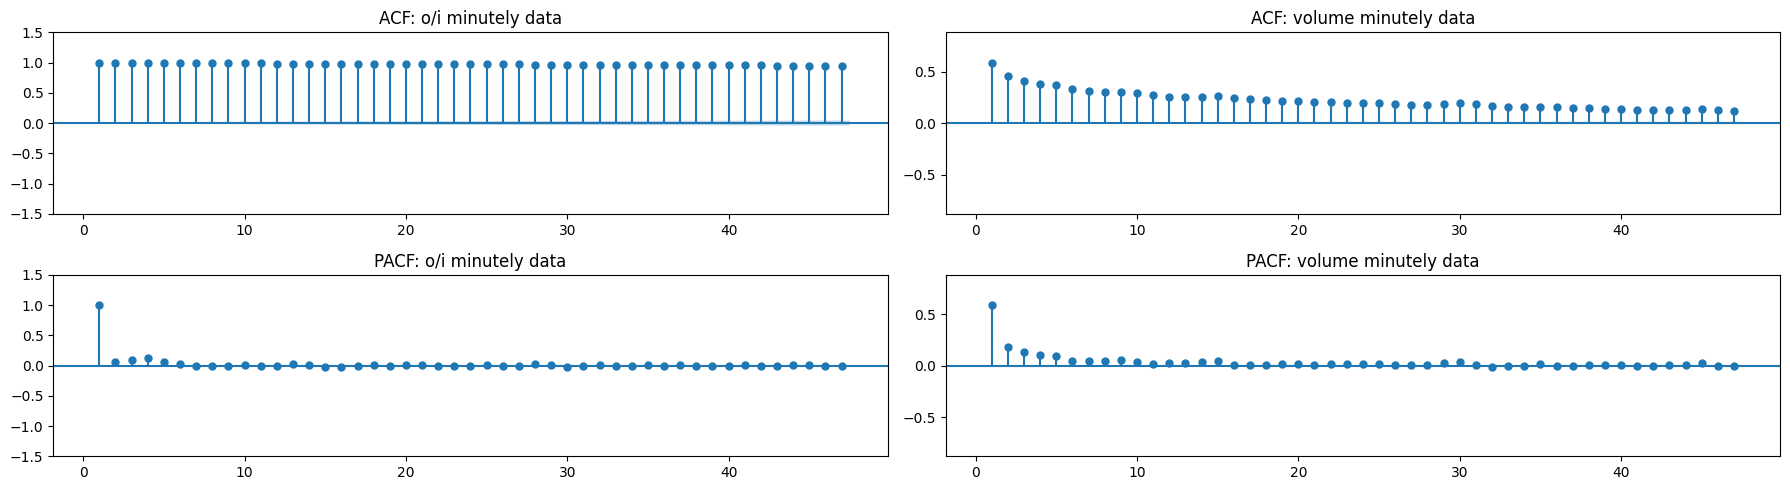

In [344]:
exp = Exploratory()
exp.plot_autocorrelations(bank_nifty_f1[['o/i','volume']],maxlags=48,label='minutely data')

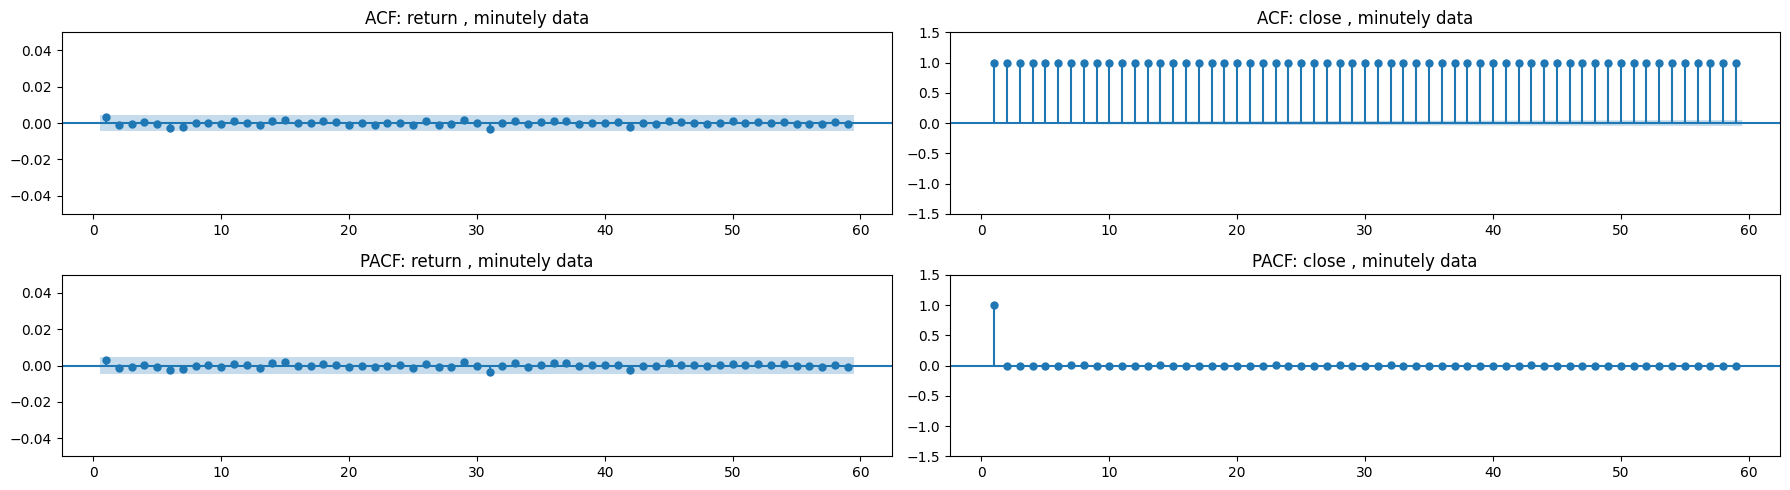

In [345]:
exp.plot_autocorrelations(bank_nifty_f1[['return','close']].dropna(),maxlags=60,label=', minutely data')

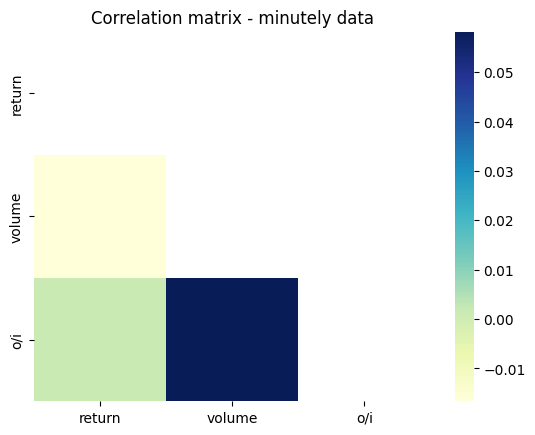

In [346]:
exp.plot_corr(bank_nifty_f1[['return','volume','o/i']],title='Correlation matrix - minutely data')

## 2.1 Mean reversion

In [347]:
st = Strategy()
bb_high,bb_low,bb_sig_discrete,bb_sig_cont = st.bb_signal(bank_nifty_f1.copy())

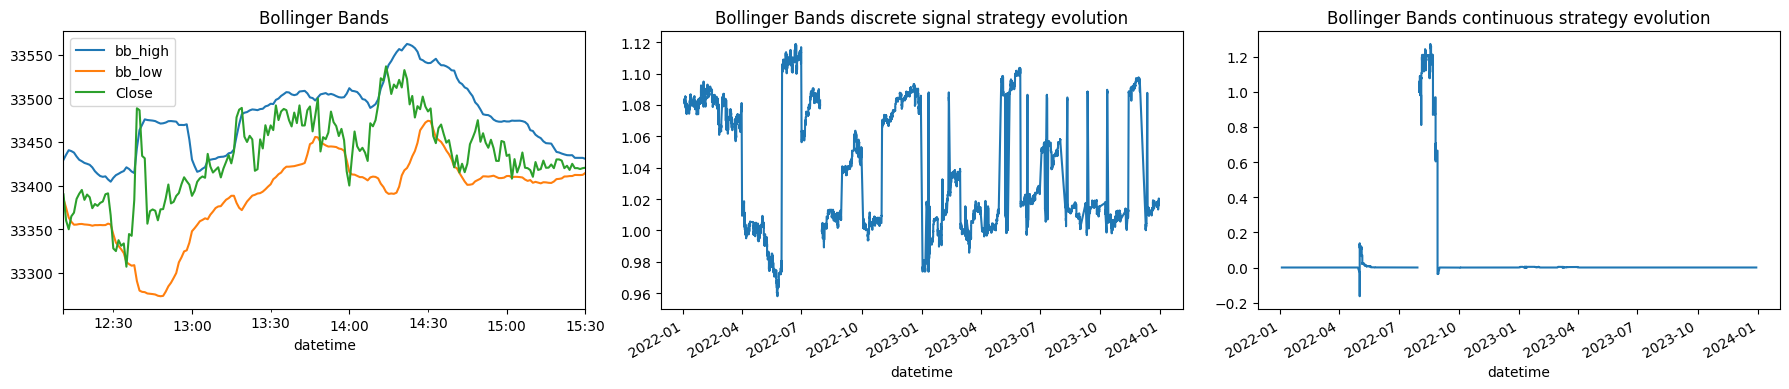

In [348]:
fig,ax = plt.subplots(1,3,figsize=(18,4))

pd.DataFrame({'bb_high':bb_high,
              'bb_low':bb_low,
              'Close':bank_nifty_f1['close'],
              },index=bank_nifty_f1.index).tail(200).plot(ax=ax[0],title='Bollinger Bands')

(1+pd.Series(bb_sig_discrete,index=bank_nifty_f1.index).shift(1)*bank_nifty_f1['return']).cumprod().plot(ax=ax[1],title='Bollinger Bands discrete signal strategy evolution')

(1+pd.Series(bb_sig_cont,index=bank_nifty_f1.index).shift(1)*bank_nifty_f1['return']).cumprod().plot(ax=ax[2],title='Bollinger Bands continuous strategy evolution')

plt.tight_layout()
plt.show()

In [372]:
# bank_nifty_f1['close'].plot(figsize=(12,5),title='Bank Nifty - Close')

<Axes: xlabel='datetime'>

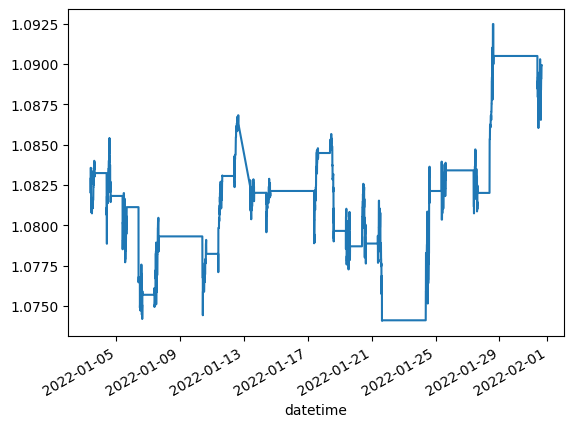

In [366]:
(1+pd.Series(bb_sig_discrete,index=bank_nifty_f1.index).shift(1)*bank_nifty_f1['return']).cumprod()['01-2022'].plot()

In [349]:
# pd.Series(bb_sig_cont,index=bank_nifty_f1.index).shift(1).head(200).plot(figsize=(12,5),title='Bollinger Bands continuous signal evolution')

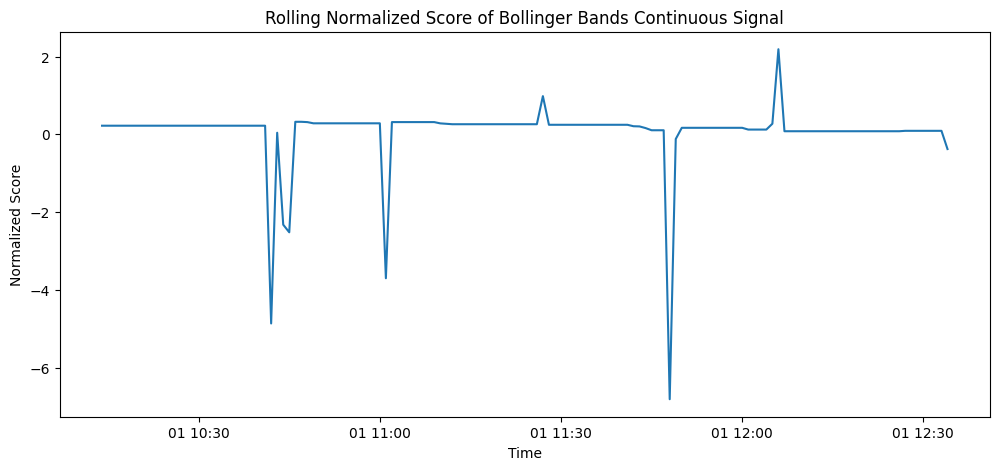

In [307]:
rolling_window = 60  # Define the rolling window size (e.g., 60 minutes)

# Calculate the rolling mean and standard deviation of the continuous signal
rolling_mean = pd.Series(bb_sig_cont, index=bank_nifty_f1.index).rolling(window=rolling_window).mean()
rolling_std = pd.Series(bb_sig_cont, index=bank_nifty_f1.index).rolling(window=rolling_window).std()

# Calculate the rolling normalized score (z-score)
rolling_normalized_score = (pd.Series(bb_sig_cont, index=bank_nifty_f1.index) - rolling_mean) / rolling_std

# Plot the rolling normalized score
plt.figure(figsize=(12, 5))
plt.plot(rolling_normalized_score.head(200))
plt.title('Rolling Normalized Score of Bollinger Bands Continuous Signal')
plt.xlabel('Time')
plt.ylabel('Normalized Score')
plt.show()


### Robustness check - Bollinger bands strategy

In [308]:
# _,_,bb_signal = st.bb_signal(data,window=15,
#                                      window_dev=2)
# pd.Series(bb_signal,index=data.index).shift(1).plot(figsize=(12,5),title='Bollinger Bands signal evolution')
# # (1+pd.Series(bb_signal,index=data.index).shift(1)*data['return']).cumprod().head(200).plot()

ValueError: too many values to unpack (expected 3)

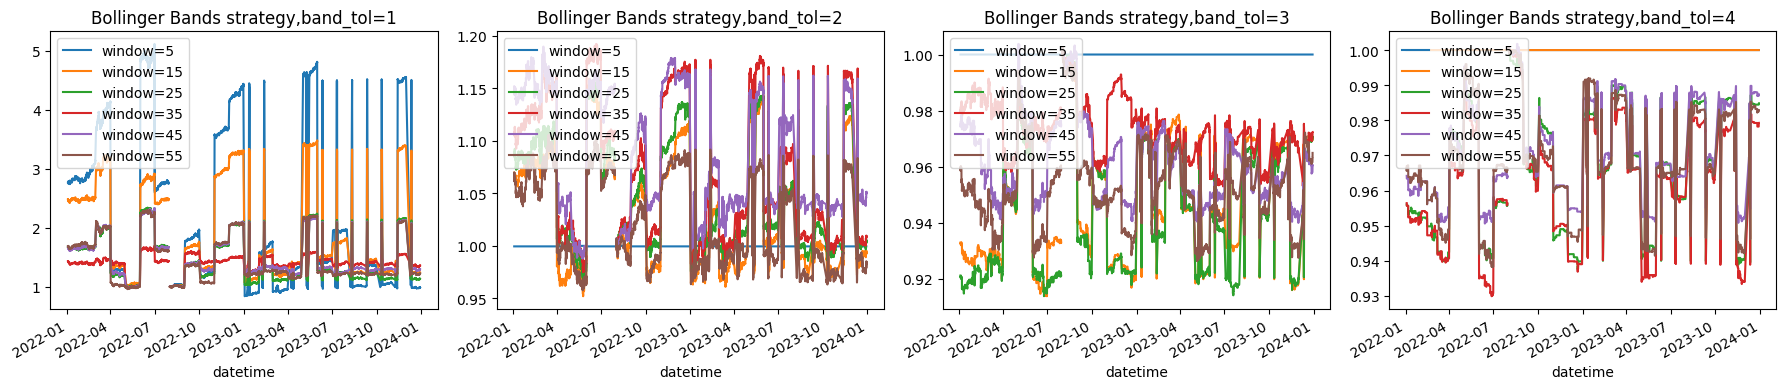

Strategy  band_tol  window  lag  Sharpe Ratio  Sortino Ratio  \
0   Bollinger Bands         1       5    0      0.678090       0.676976   
1   Bollinger Bands         1       5    1      0.402834       0.362927   
2   Bollinger Bands         1      15    0      0.467674       0.423861   
3   Bollinger Bands         1      15    1      0.217782       0.172184   
4   Bollinger Bands         1      25    0      0.379135       0.461889   
5   Bollinger Bands         1      25    1      0.244049       0.278191   
6   Bollinger Bands         1      35    0      0.338835       0.287353   
7   Bollinger Bands         1      35    1      0.181805       0.175086   
8   Bollinger Bands         1      45    0      0.353103       0.482395   
9   Bollinger Bands         1      45    1      0.351255       0.583942   
10  Bollinger Bands         1      55    0      0.327146       0.405571   
11  Bollinger Bands         1      55    1      0.261780       0.332298   
14  Bollinger Bands         2      15    0      0.293906       0.118498   
15  Bollinger Bands         2      15    1      0.533991       0.228371   
16  Bollinger Bands         2      25    0      0.317848       0.137482   
17  Bollinger Bands         2      25    1      0.246754       0.107560   
18  Bollinger Bands         2      35    0      0.347437       0.160962   
19  Bollinger Bands         2      35    1      0.143168       0.064484   
20  Bollinger Bands         2      45    0      0.278446       0.122926   
21  Bollinger Bands         2      45    1      0.155198       0.068864   
22  Bollinger Bands         2      55    0      0.162007       0.072437   
23  Bollinger Bands         2      55    1      0.045290       0.019947   
26  Bollinger Bands         3      15    0     -0.518869      -0.052249   
27  Bollinger Bands         3      15    1     -0.091478      -0.007923   
28  Bollinger Bands         3      25    0     -0.414928      -0.058379   
29  Bollinger Bands         3      25    1      0.090491       0.013003   
30  Bollinger Bands         3      35    0     -0.122100      -0.020067   
31  Bollinger Bands         3      35    1     -0.031621      -0.005112   
32  Bollinger Bands         3      45    0     -0.201902      -0.035079   
33  Bollinger Bands         3      45    1      0.084393       0.014952   
34  Bollinger Bands         3      55    0     -0.258298      -0.047442   
35  Bollinger Bands         3      55    1      0.018516       0.003647   
40  Bollinger Bands         4      25    0     -0.529055      -0.028339   
41  Bollinger Bands         4      25    1     -0.021446      -0.000855   
42  Bollinger Bands         4      35    0     -0.576604      -0.034710   
43  Bollinger Bands         4      35    1     -0.066009      -0.003447   
44  Bollinger Bands         4      45    0     -0.378525      -0.024877   
45  Bollinger Bands         4      45    1      0.026523       0.001625   
46  Bollinger Bands         4      55    0     -0.426237      -0.029887   
47  Bollinger Bands         4      55    1     -0.000526      -0.000039   

    Max Drawdown  VaR (95%)  Expected Shortfall (95%)  Total return  
0       0.166784  -0.000511             -9.595403e-04      4.111010  
1       0.123503  -0.000492             -9.600174e-04      1.413842  
2       0.012333  -0.000526             -9.828336e-04      1.913339  
3       0.040649  -0.000511             -9.822988e-04      0.560898  
4       0.018609  -0.000533             -9.863565e-04      1.327236  
5       0.209813  -0.000522             -9.763178e-04      0.678229  
6       0.038391  -0.000538             -9.832720e-04      0.693065  
7       0.149585  -0.000529             -9.663961e-04      0.285131  
8       0.041478  -0.000541             -9.927979e-04      1.332768  
9       0.142573  -0.000533             -9.761117e-04      1.347699  
10      0.170143  -0.000541             -1.013415e-03      1.268308  
11      0.227898  -0.000536             -9.893835e-04      0.624686  
14      0.052790   0.0000

In [309]:
data = bank_nifty_f1.copy()
max_band_tol = 4
fig,ax = plt.subplots(1,max_band_tol,figsize=(18,4))
results = []
for band_tol in range(1,1+max_band_tol):
    legend = []
    for window in range(5,60,10):
        _,_,bb_signal,_ = st.bb_signal(data,window=window,
                                     window_dev=band_tol)
        (1+pd.Series(bb_signal,index=data.index).shift(1)*data['return']).cumprod().plot(
            title=f'Bollinger Bands strategy,band_tol={band_tol}',ax=ax[band_tol-1])
        legend.append(f'window={window}')
        for lag in range(1,3):
            strategy_returns = pd.Series(bb_signal, index=data.index).shift(lag) * \
                          data['return']
            analytics = st.calculate_analytics(strategy_returns)
            results.append({
                'Strategy': 'Bollinger Bands',
                'band_tol': band_tol,
                'window': window,
                'lag': lag-1,
                **analytics
            })
    ax[band_tol-1].legend(legend,loc='upper left')
plt.tight_layout()
plt.show()

analytics_df_0 = pd.DataFrame(results)
display(analytics_df_0.dropna())

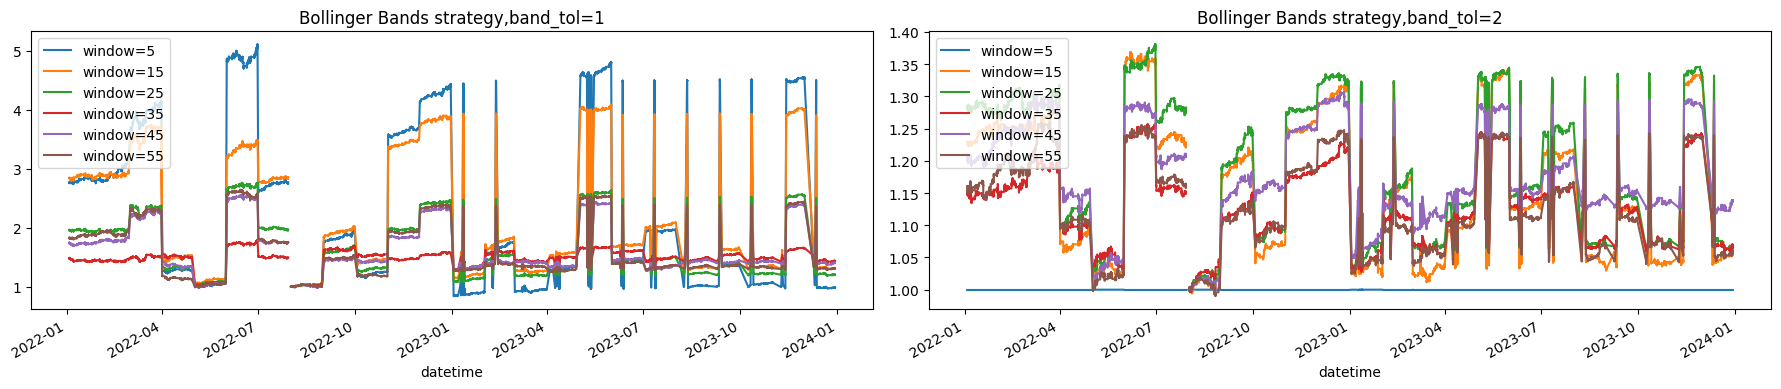

Strategy  band_tol  window  lag  Sharpe Ratio  Sortino Ratio  \
0   Bollinger Bands         1       5    0      0.678090       0.676976   
1   Bollinger Bands         1       5    1      0.402834       0.362927   
2   Bollinger Bands         1      15    0      0.539499       0.489640   
3   Bollinger Bands         1      15    1      0.228485       0.180992   
4   Bollinger Bands         1      25    0      0.449528       0.550280   
5   Bollinger Bands         1      25    1      0.230650       0.263766   
6   Bollinger Bands         1      35    0      0.373010       0.317594   
7   Bollinger Bands         1      35    1      0.189615       0.183553   
8   Bollinger Bands         1      45    0      0.389364       0.534662   
9   Bollinger Bands         1      45    1      0.338099       0.564599   
10  Bollinger Bands         1      55    0      0.372693       0.464012   
11  Bollinger Bands         1      55    1      0.257651       0.327383   
14  Bollinger Bands         2      15    0      0.694972       0.291066   
15  Bollinger Bands         2      15    1      0.595368       0.269653   
16  Bollinger Bands         2      25    0      0.677492       0.309601   
17  Bollinger Bands         2      25    1      0.179225       0.080055   
18  Bollinger Bands         2      35    0      0.461999       0.220820   
19  Bollinger Bands         2      35    1      0.168163       0.078364   
20  Bollinger Bands         2      45    0      0.460732       0.210895   
21  Bollinger Bands         2      45    1      0.087153       0.039612   
22  Bollinger Bands         2      55    0      0.402626       0.186366   
23  Bollinger Bands         2      55    1      0.029447       0.012969   

    Max Drawdown  VaR (95%)  Expected Shortfall (95%)  Total return  
0       0.166784  -0.000511                 -0.000960      4.111010  
1       0.123503  -0.000492                 -0.000960      1.413842  
2       0.006626  -0.000524                 -0.000975      2.484275  
3       0.023079  -0.000510                 -0.000980      0.603107  
4       0.010495  -0.000531                 -0.000977      1.767763  
5       0.192520  -0.000522                 -0.000974      0.622972  
6       0.011648  -0.000538                 -0.000976      0.793617  
7       0.183057  -0.000529                 -0.000962      0.301290  
8       0.024752  -0.000540                 -0.000982      1.572845  
9       0.167140  -0.000533                 -0.000973      1.264583  
10      0.067371  -0.000539                 -0.001003      1.586170  
11      0.272851  -0.000535                 -0.000987      0.610558  
14      0.007547   0.000000                 -0.000021      0.359136  
15      0.010724  -0.000009                 -0.000371      0.291400  
16      0.001430  -0.000057                 -0.000452      0.380948  
17      0.007537  -0.000075                 -0.000444      0.088535  
18      0.005477  -0.000088                 -0.000478      0.256734  
19      0.046900  -0.000097                 -0.000462      0.083257  
20      0.003501  -0.000108                 -0.000497      0.274889  
21      0.052879  -0.000112                 -0.000484      0.042445  
22      0.014236  -0.000120                 -0.000509      0.239335  
23      0.095810  -0.000120                 -0.000505      0.011314

In [310]:
data = bank_nifty_f1.copy()
max_band_tol = 2
fig,ax = plt.subplots(1,max_band_tol,figsize=(18,4))
results = []
for band_tol in range(1,1+max_band_tol):
    legend = []
    for window in range(5,60,10):
        bb_high,bb_low,bb_signal,_ = st.bb_signal(data,window=window,
                                                  window_dev=band_tol)
        bb_high_3,bb_low_3,_,_ = st.bb_signal(data,window=window,
                                                  window_dev=3)
        bb_signal = np.where(data['close'] > bb_high_3,1,bb_signal)
        bb_signal = np.where(data['close'] < bb_low_3,-1,bb_signal)

        (1+pd.Series(bb_signal,index=data.index).shift(1)*data['return']).cumprod().plot(
            title=f'Bollinger Bands strategy,band_tol={band_tol}',ax=ax[band_tol-1])
        legend.append(f'window={window}')
        for lag in range(1,3):
            strategy_returns = pd.Series(bb_signal, index=data.index).shift(lag) * \
                          data['return']
            analytics = st.calculate_analytics(strategy_returns)
            results.append({
                'Strategy': 'Bollinger Bands',
                'band_tol': band_tol,
                'window': window,
                'lag': lag-1,
                **analytics
            })
    ax[band_tol-1].legend(legend,loc='upper left')
plt.tight_layout()
plt.show()

analytics_df = pd.DataFrame(results)
display(analytics_df.dropna())

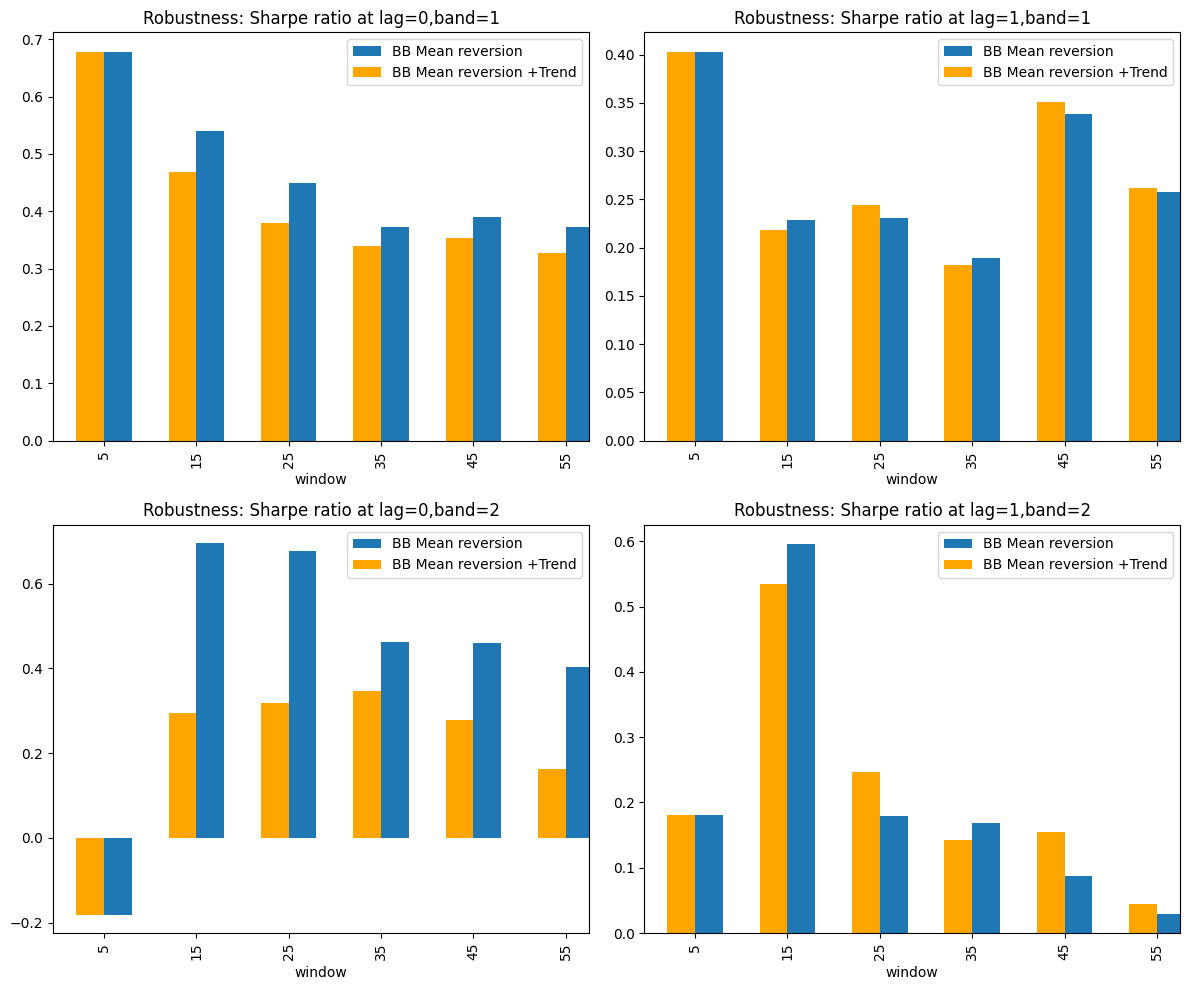

In [311]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
analytics_df.loc[(analytics_df['lag']==0)&(analytics_df['band_tol']==1),['Sharpe Ratio','window']].set_index('window').plot.bar(
    title='Robustness: Sharpe ratio at lag=0,band=1',ax=ax[0,0],position=0,width=0.3)
analytics_df_0.loc[(analytics_df_0['lag']==0)&(analytics_df_0['band_tol']==1),['Sharpe Ratio','window']].set_index('window').plot.bar(
    ax=ax[0,0],position=1,width=0.3,color='orange')
ax[0, 0].legend(['BB Mean reversion', 'BB Mean reversion +Trend'])
analytics_df.loc[(analytics_df['lag']==1)&(analytics_df['band_tol']==1),['Sharpe Ratio','window']].set_index('window').plot.bar(
    title='Robustness: Sharpe ratio at lag=1,band=1',ax=ax[0,1],position=0,width=0.3)
analytics_df_0.loc[(analytics_df_0['lag']==1)&(analytics_df_0['band_tol']==1),['Sharpe Ratio','window']].set_index('window').plot.bar(
    ax=ax[0,1],position=1,width=0.3,color='orange')
ax[0, 1].legend(['BB Mean reversion', 'BB Mean reversion +Trend'])
analytics_df.loc[(analytics_df['lag']==0)&(analytics_df['band_tol']==2),['Sharpe Ratio','window']].set_index('window').plot.bar(
    title='Robustness: Sharpe ratio at lag=0,band=2',ax=ax[1,0],position=0,width=0.3)
analytics_df_0.loc[(analytics_df_0['lag']==0)&(analytics_df_0['band_tol']==2),['Sharpe Ratio','window']].set_index('window').plot.bar(
    ax=ax[1,0],position=1,width=0.3,color='orange')
ax[1, 0].legend(['BB Mean reversion', 'BB Mean reversion +Trend'])
analytics_df.loc[(analytics_df['lag']==1)&(analytics_df['band_tol']==2),['Sharpe Ratio','window']].set_index('window').plot.bar(
    title='Robustness: Sharpe ratio at lag=1,band=2',ax=ax[1,1],position=0,width=0.3)
analytics_df_0.loc[(analytics_df_0['lag']==1)&(analytics_df_0['band_tol']==2),['Sharpe Ratio','window']].set_index('window').plot.bar(
    ax=ax[1,1],position=1,width=0.3,color='orange')
ax[1, 1].legend(['BB Mean reversion', 'BB Mean reversion +Trend'])

plt.tight_layout()
plt.show()

# The code below this cell was developed based on the hourly yahoo finance data wihch we are no longer using. Hence below cells will not work currently but have been left in the notebook to leverage upon.

## 2.3 Seasonality

In [ ]:
STOP

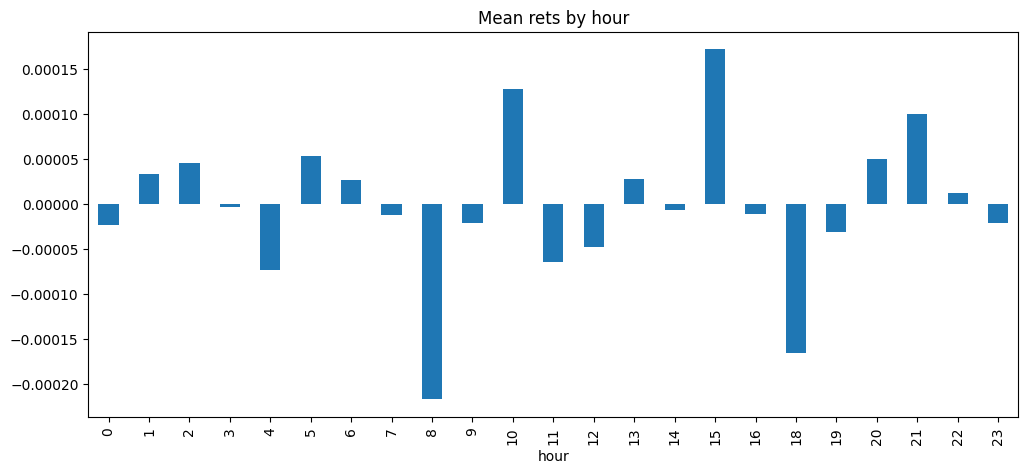

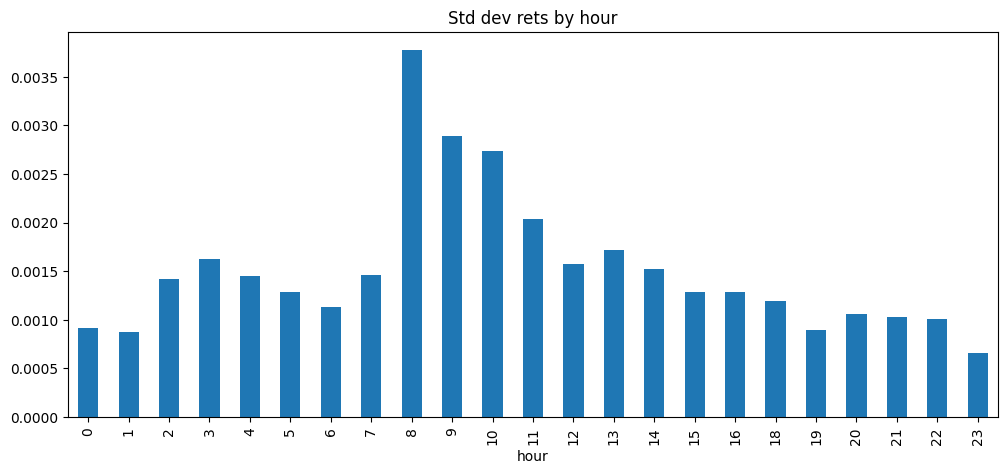

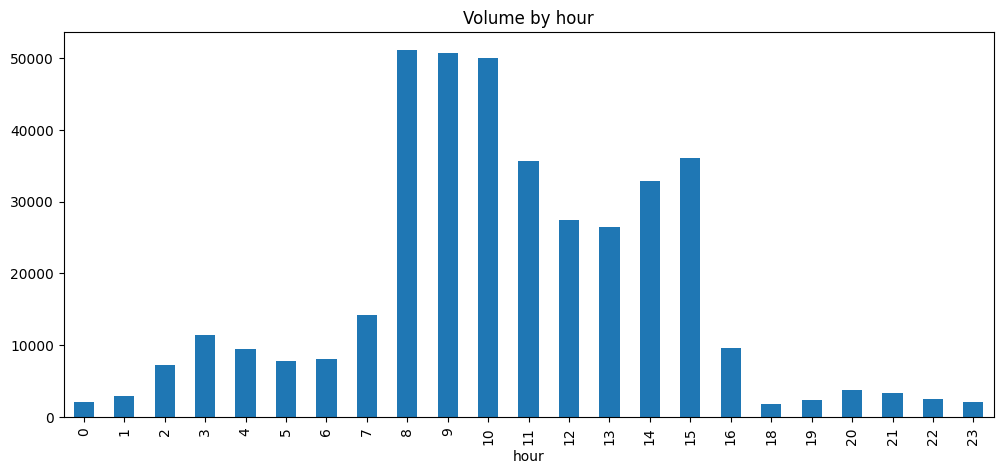

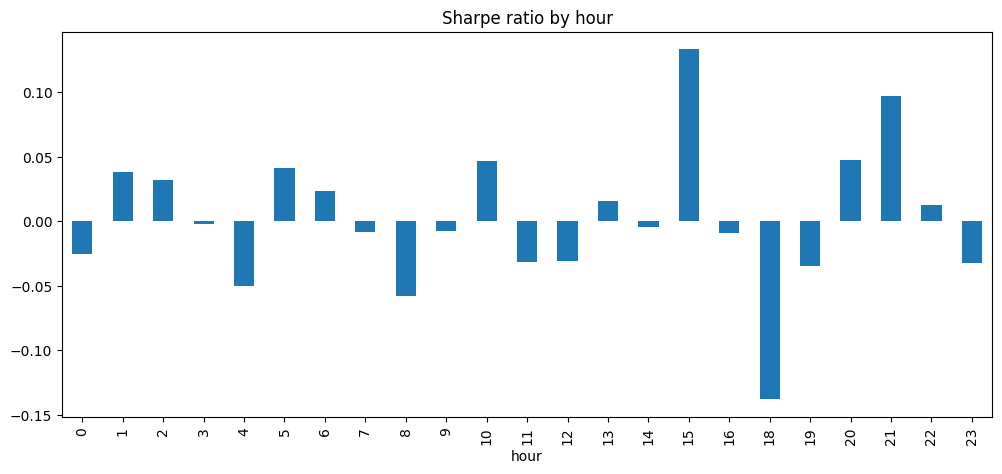

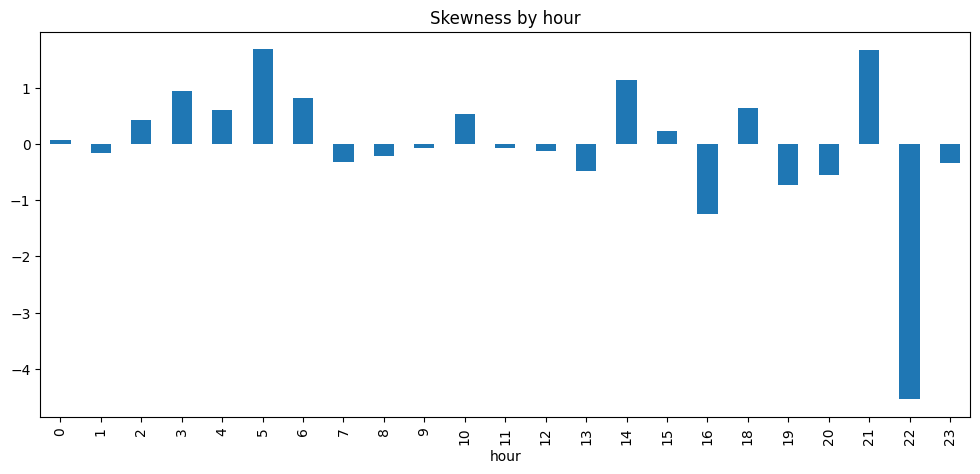

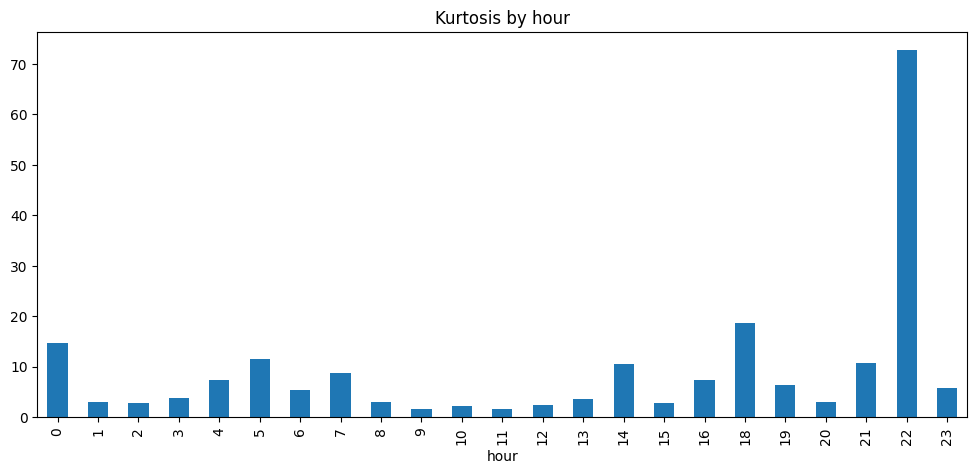

In [ ]:
# all_data.loc['ZB=F']['hour']
# lb = 1080
lb = all_data.loc['ZB=F'].shape[0]
mean_rets_hour = all_data.loc['ZB=F'].iloc[-lb:,:].groupby('hour')['rets'].mean()
std_rets_hour = all_data.loc['ZB=F'].iloc[-lb:,:].groupby('hour')['rets'].std()
sharpe_hour = mean_rets_hour/std_rets_hour
volumes_hour = all_data.loc['ZB=F'].iloc[-lb:,:].groupby('hour')['Volume'].mean()
skewness_hour = all_data.loc['ZB=F'].iloc[-lb:,:].groupby('hour')['rets'].apply(lambda x: skew(x))
kurtosis_hour = all_data.loc['ZB=F'].iloc[-lb:,:].groupby('hour')['rets'].apply(lambda x: kurtosis(x))

mean_rets_hour.plot.bar(figsize=(12,5),title='Mean rets by hour')
plt.show()
std_rets_hour.plot.bar(figsize=(12,5),title='Std dev rets by hour')
plt.show()
volumes_hour.plot.bar(figsize=(12,5),title='Volume by hour')
plt.show()
sharpe_hour.plot.bar(figsize=(12,5),title='Sharpe ratio by hour')
plt.show()
skewness_hour.plot.bar(figsize=(12,5),title='Skewness by hour')
plt.show()
kurtosis_hour.plot.bar(figsize=(12,5),title='Kurtosis by hour')
plt.show()

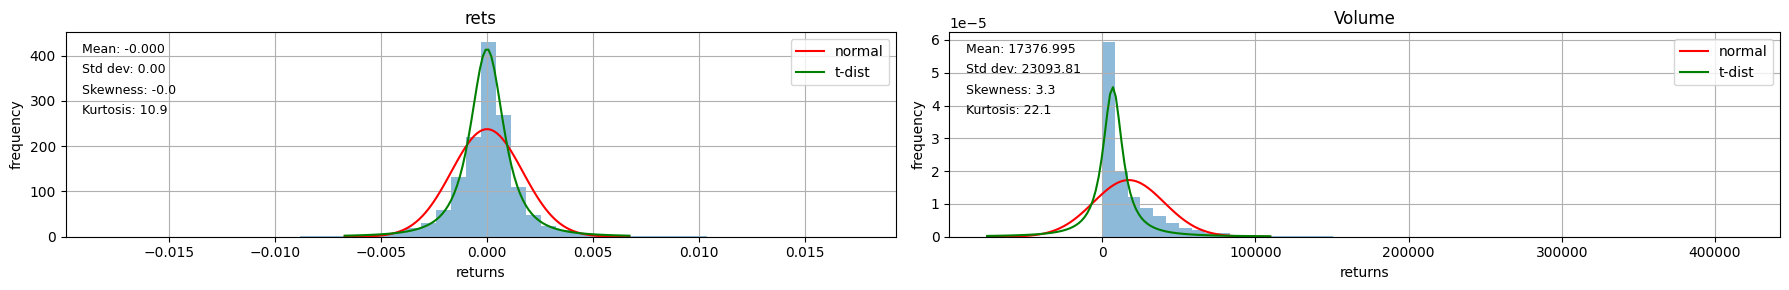

In [ ]:

exp.plot_histograms(all_data.loc['ZB=F'][['rets','Volume']])

Text(0.5, 1.0, 'Hourly returns')

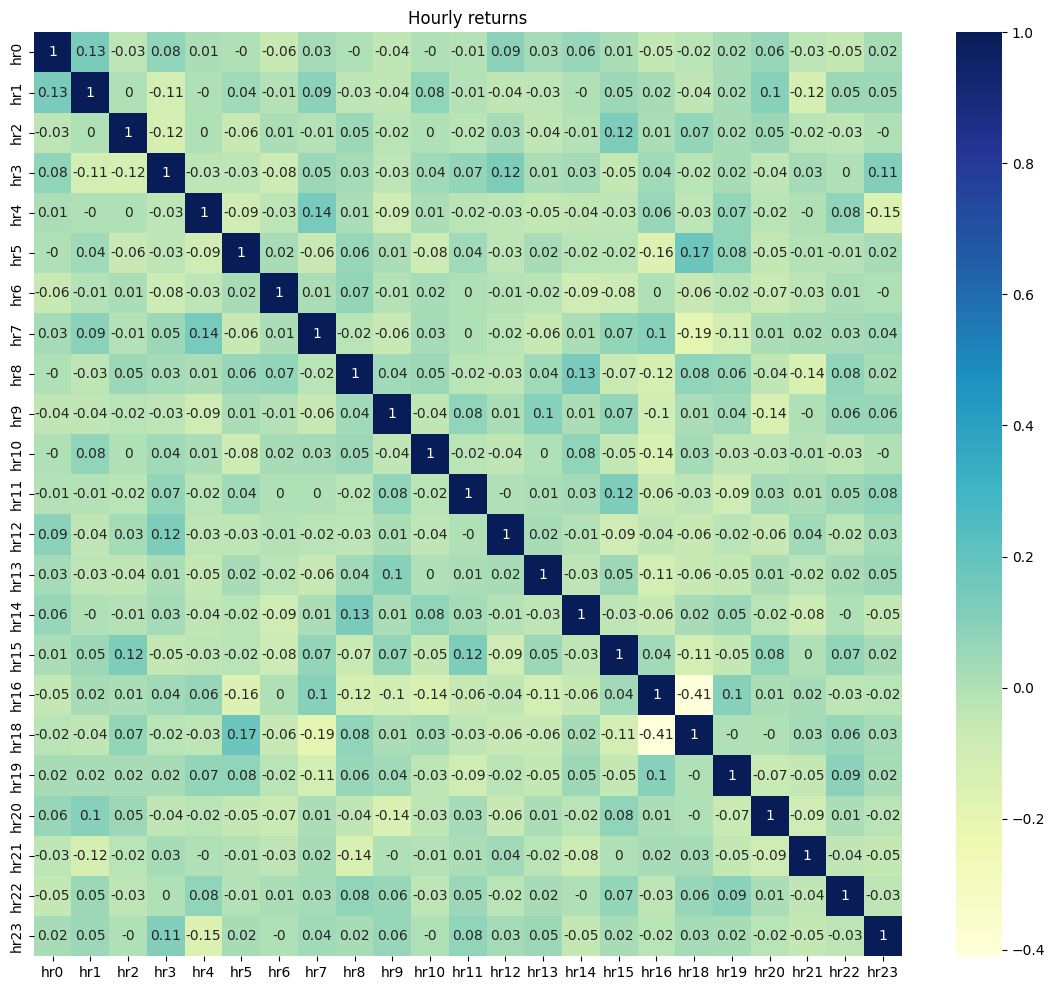

In [ ]:
plt.figure(figsize=(14, 12))
hourly_returns = pd.DataFrame()
# Calculate hourly returns
for hr in all_data.loc['ZB=F']['hour'].unique():
    # print(hr)
    hour_ret = all_data.loc['ZB=F'].loc[all_data.loc['ZB=F']['hour']==hr, 'rets'].to_frame(f'hr{hr}')
    hour_ret.index = all_data.loc['ZB=F'].loc[all_data.loc['ZB=F']['hour']==hr, 'rets'].index.date
    hourly_returns = pd.concat([hourly_returns,hour_ret],axis=1)
# hourly_returns
# Calculate correlation matrix
# Reorder columns to start with 'hr0'
cols = hourly_returns.columns.tolist()
cols = cols[-1:] + cols[:-1]  # Move the last column ('hr0') to the front
hourly_returns = hourly_returns[cols].dropna()

# Calculate correlation matrix
correlation_matrix = hourly_returns.corr()

sns.heatmap(correlation_matrix.round(2), cmap="YlGnBu",annot=True)
plt.title('Hourly returns')


In [ ]:
# all_data.loc['ZB=F']['hour'].unique()

In [ ]:
# range(1,int((hourly_returns.shape[1]+1)/ncols))

1


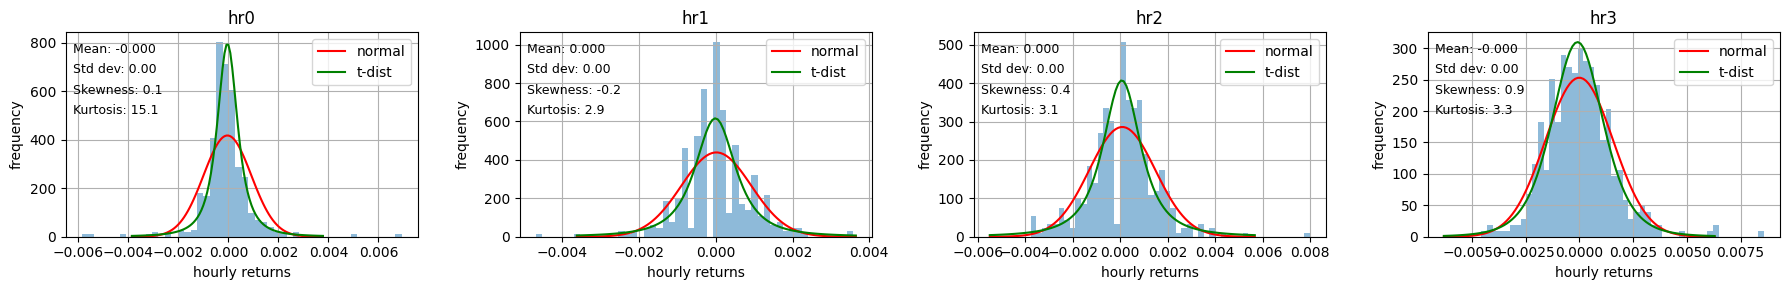

2


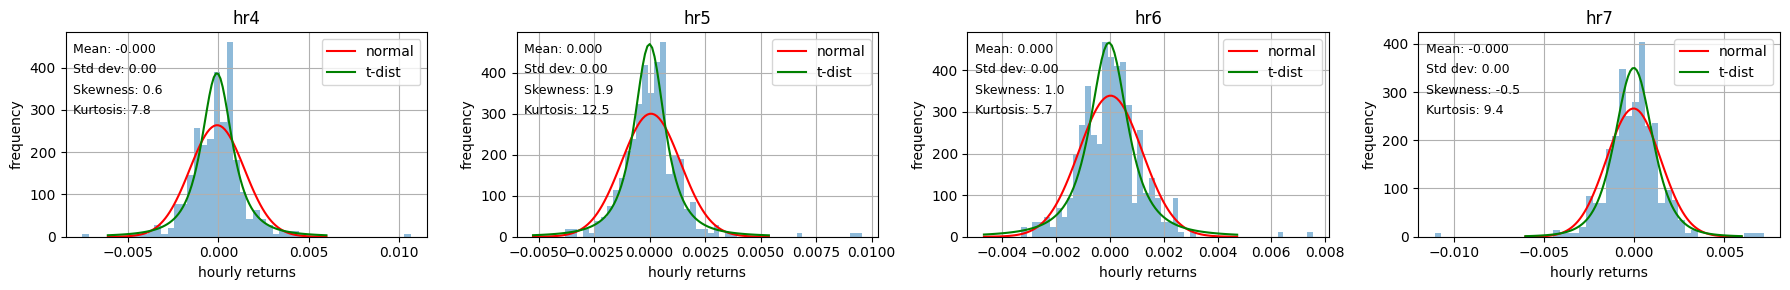

3


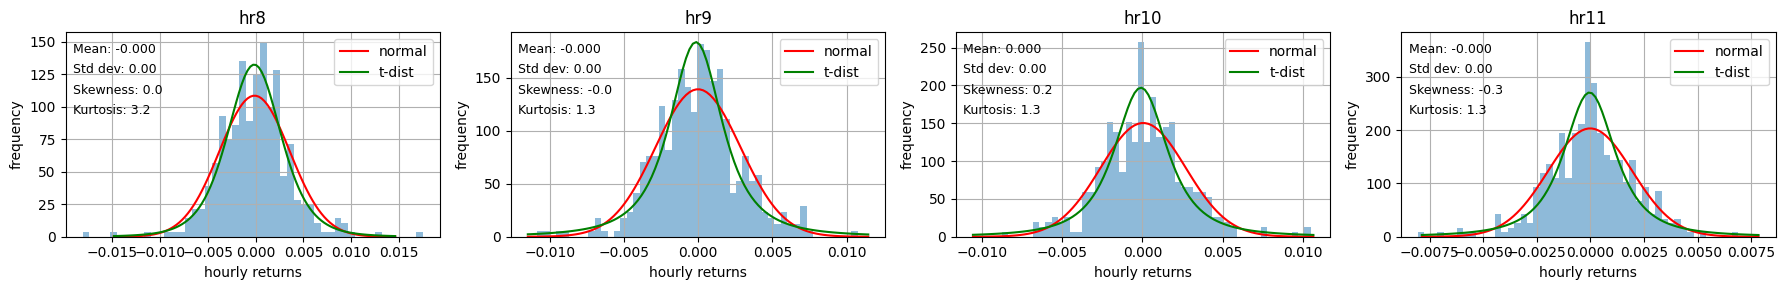

4


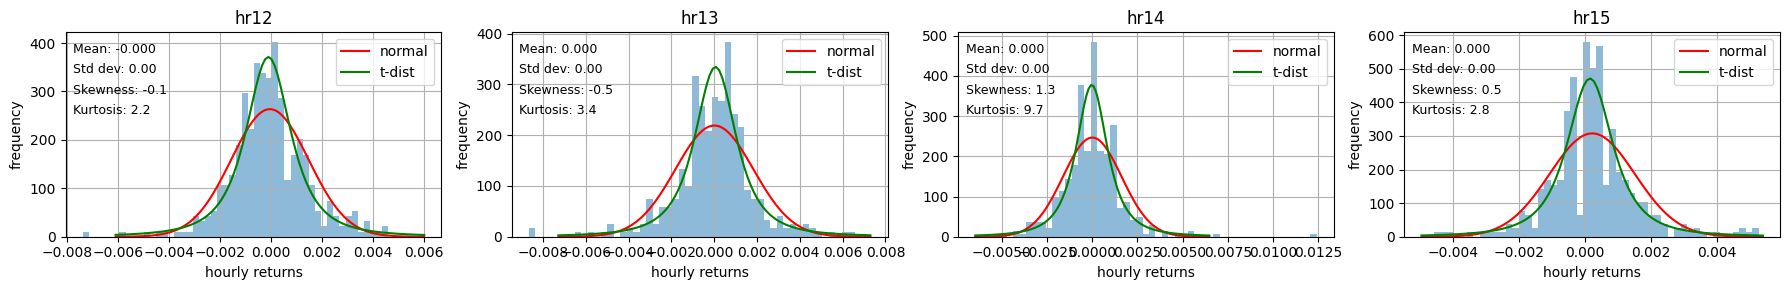

5


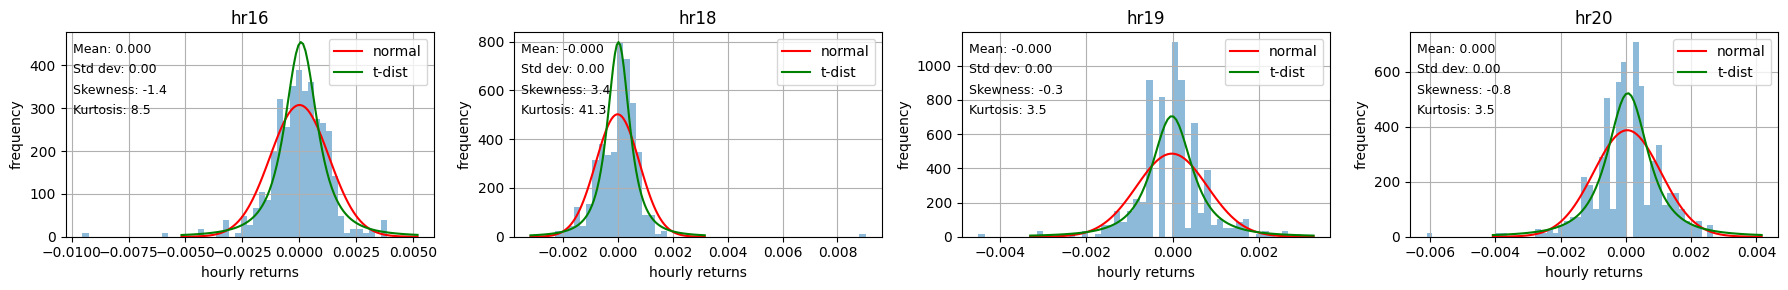

6


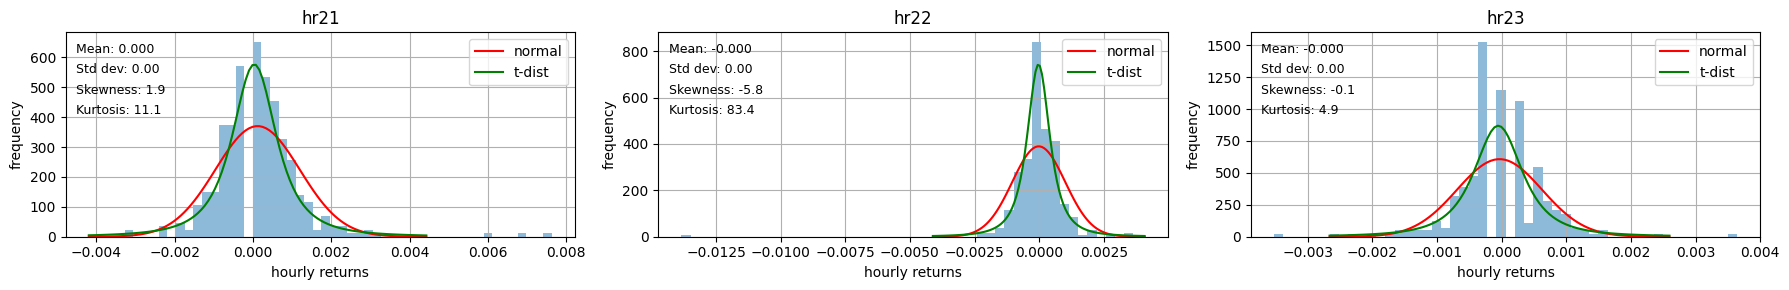

In [ ]:
ncols = 4
for x in range(1,1+int((hourly_returns.shape[1]+1)/ncols)):
    print(x)
    exp.plot_histograms(hourly_returns.iloc[:,ncols*(x-1):ncols*x],label='hourly returns')
    plt.show()

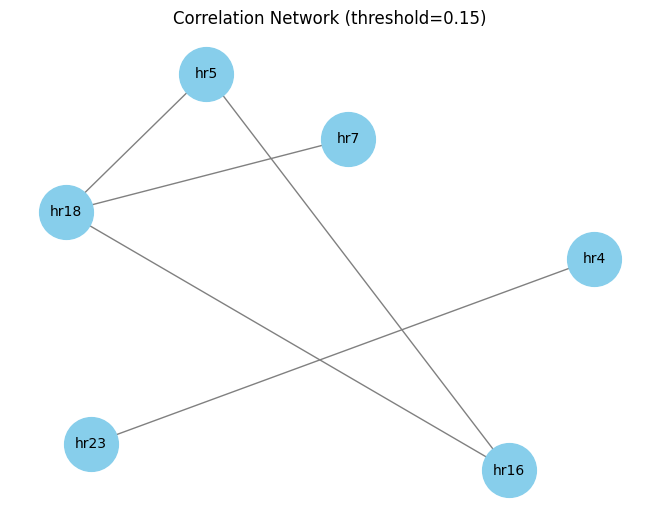

In [ ]:
exp.correlation_network(correlation_matrix,threshold=0.15)

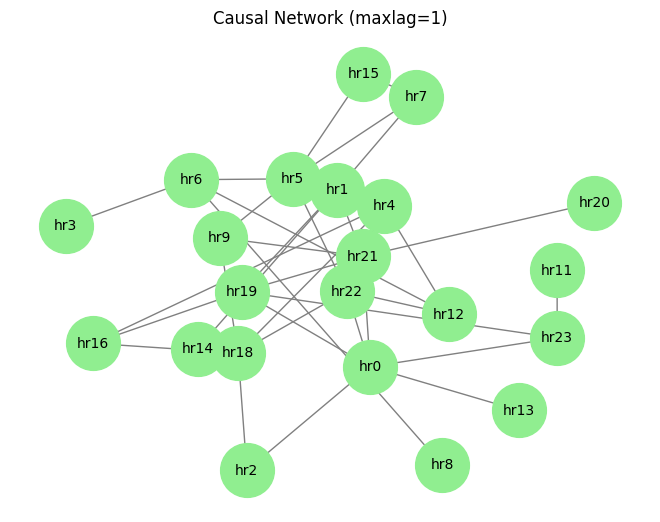

In [ ]:
exp.causal_network(hourly_returns,maxlag=1)

In [ ]:
exp.granger_causality(hourly_returns,maxlag=1)

Granger Causality Test Results:
Does hr0 cause hr1?
Lag 1: p-value = 0.8694
----
Does hr0 cause hr2?
Lag 1: p-value = 0.0045
  => Significant evidence of causality at lag 1
----
Does hr0 cause hr3?
Lag 1: p-value = 0.3187
----
Does hr0 cause hr4?
Lag 1: p-value = 0.3202
----
Does hr0 cause hr5?
Lag 1: p-value = 0.9543
----
Does hr0 cause hr6?
Lag 1: p-value = 0.6947
----
Does hr0 cause hr7?
Lag 1: p-value = 0.55
----
Does hr0 cause hr8?
Lag 1: p-value = 0.7602
----
Does hr0 cause hr9?
Lag 1: p-value = 0.2191
----
Does hr0 cause hr10?
Lag 1: p-value = 0.3105
----
Does hr0 cause hr11?
Lag 1: p-value = 0.5525
----
Does hr0 cause hr12?
Lag 1: p-value = 0.0929
----
Does hr0 cause hr13?
Lag 1: p-value = 0.2685
----
Does hr0 cause hr14?
Lag 1: p-value = 0.4885
----
Does hr0 cause hr15?
Lag 1: p-value = 0.255
----
Does hr0 cause hr16?
Lag 1: p-value = 0.5965
----
Does hr0 cause hr18?
Lag 1: p-value = 0.9383
----
Does hr0 cause hr19?
Lag 1: p-value = 0.6995
----
Does hr0 cause hr20?
Lag 1: p-va

Causal Matrix:


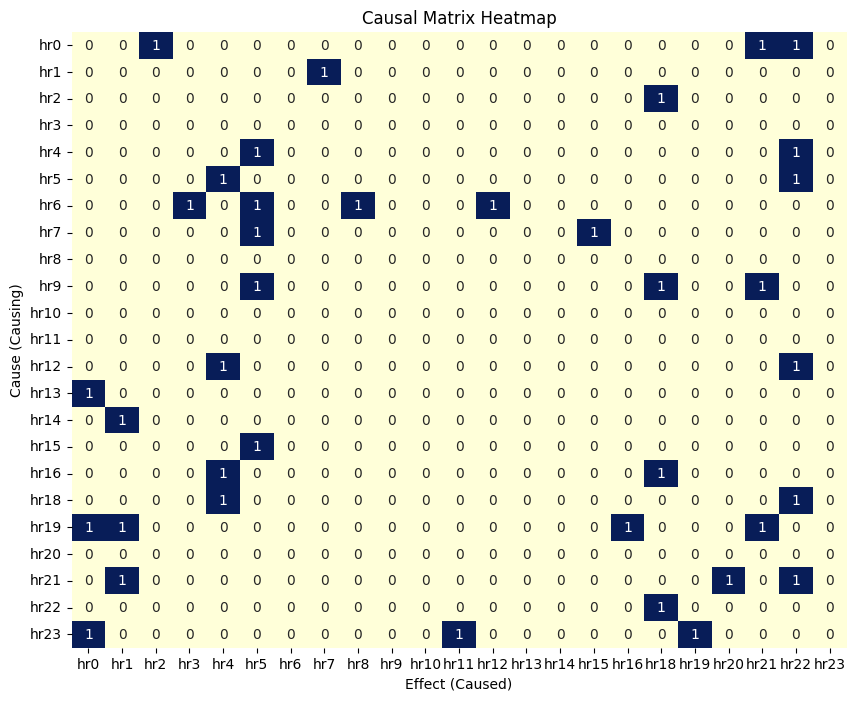

In [ ]:
# Calculate the causal matrix
causal_result = exp.causal_matrix(hourly_returns, maxlag=1)

# Display the causal matrix
print("Causal Matrix:")
# display(causal_result)

# Visualize the causal matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(causal_result, annot=True, cmap="YlGnBu", cbar=False)
plt.title("Causal Matrix Heatmap")
plt.xlabel("Effect (Caused)")  # Label for columns (effects)
plt.ylabel("Cause (Causing)")  # Label for rows (causes)
plt.show()

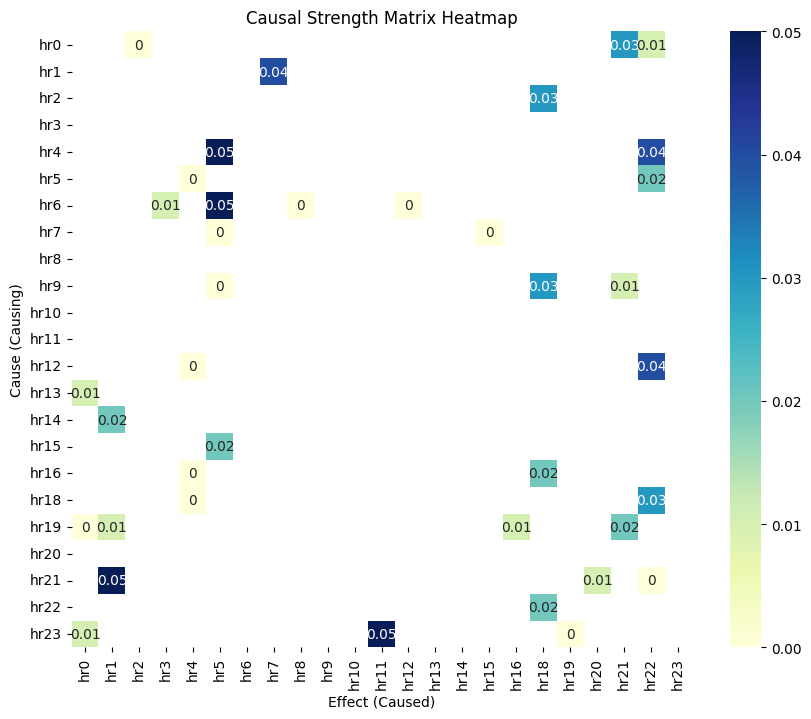

In [ ]:
causal_strength_matrix = exp.causal_strength_matrix(hourly_returns, maxlag=1)

In [ ]:
all_data.loc['ZB=F'].head()

Open       High        Low      Close  Volume  \
Datetime                                                                        
2022-09-26 01:00:00-04:00  128.09375  128.18750  127.87500  128.06250    7756   
2022-09-26 02:00:00-04:00  128.09375  128.15625  127.62500  127.75000   10512   
2022-09-26 03:00:00-04:00  127.75000  128.25000  127.65625  127.93750   25325   
2022-09-26 04:00:00-04:00  127.93750  128.09375  127.71875  127.78125   11063   
2022-09-26 05:00:00-04:00  127.78125  128.03125  127.78125  127.90625    9455   

                               rets  hour  
Datetime                                   
2022-09-26 01:00:00-04:00  0.000000     1  
2022-09-26 02:00:00-04:00 -0.002443     2  
2022-09-26 03:00:00-04:00  0.001467     3  
2022-09-26 04:00:00-04:00 -0.001222     4  
2022-09-26 05:00:00-04:00  0.000978     5

In [ ]:
data = all_data.loc['ZB=F']['Close'].to_frame().copy()
data.tail()

Close
Datetime                            
2024-09-20 12:00:00-04:00  125.37500
2024-09-20 13:00:00-04:00  125.21875
2024-09-20 14:00:00-04:00  125.28125
2024-09-20 15:00:00-04:00  125.21875
2024-09-20 16:00:00-04:00  125.06250

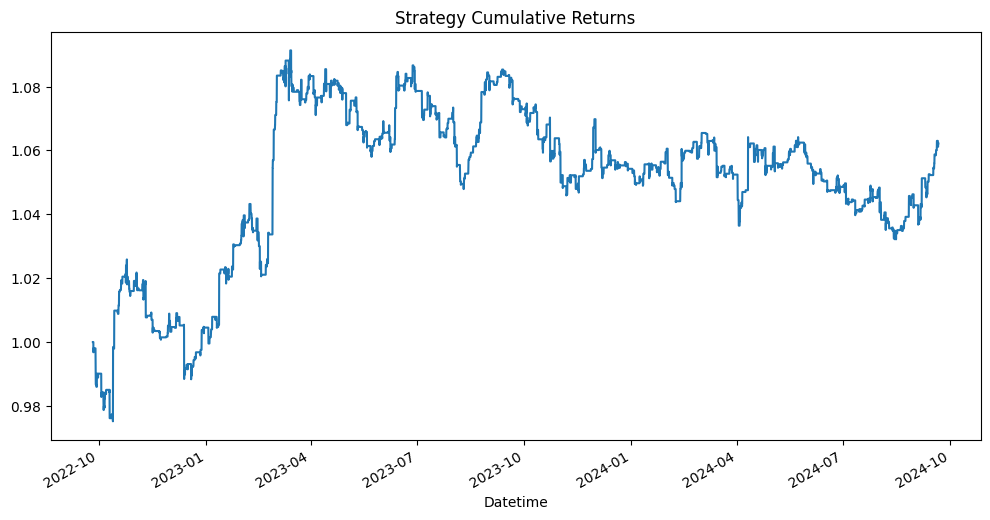

Final Portfolio Value: 106219.28


In [ ]:
st = Strategy()
st.mean_reversion(data,lookback= 12, band_tol=2)

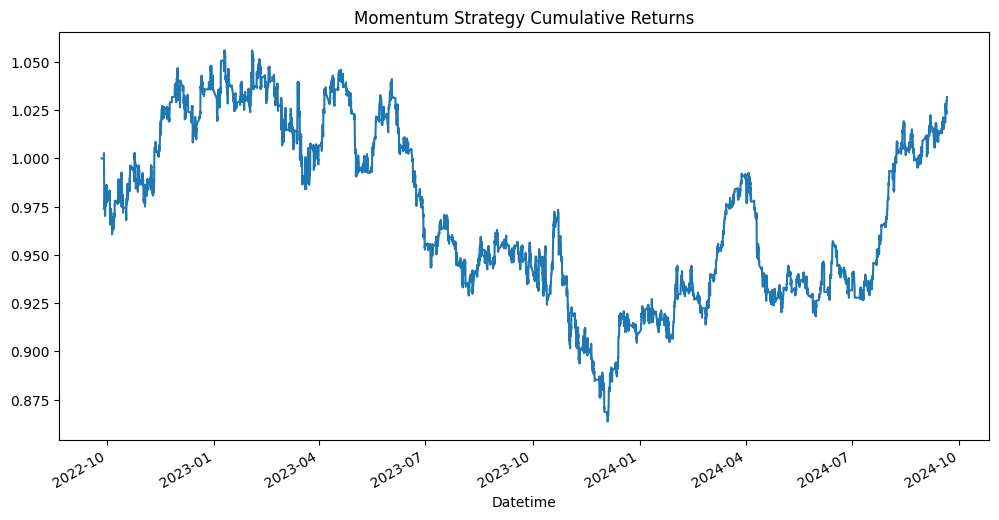

Final Portfolio Value: 103177.05


In [ ]:
st.momentum(data,st_lb=20,lt_lb=50,rsi_lb=14,rsi_ut=70,rsi_lt=30)

In [ ]:
initial_capital = 100000
data['Strategy Value'] = initial_capital * data['Cumulative']

# Show the final strategy value
print(f"Final Portfolio Value: {data['Strategy Value'].iloc[-1]:.2f}")

Final Portfolio Value: 103177.05


## Feature engineering

In [ ]:
# all_data.loc['ZB=F'][['Open','High','Low','Close','Volume']]#.to_frame()

In [ ]:
# add_all_ta_features(all_data.loc['ZB=F'][['Open','High','Low','Close','Volume']],
#                     open="Open", high="High", low="Low", close="Close",
#                     volume="Volume")

In [ ]:
# Feature Engineering
# data = all_data.loc['ZB=F']['Close'].to_frame().copy()
data = add_all_ta_features(all_data.loc['ZB=F'][['Open','High','Low','Close',
                                                 'Volume']],
                           open="Open", high="High", low="Low", close="Close",
                           volume="Volume")

# data.columns
data['SMA'] = ta.trend.sma_indicator(data['Close'], window=14)
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
data['MACD'] = ta.trend.macd(data['Close'])
data['Bollinger_High'] = ta.volatility.bollinger_hband(data['Close'])
data['Bollinger_Low'] = ta.volatility.bollinger_lband(data['Close'])


def hurst_exponent(series):
    H, _, _ = compute_Hc(series)
    return H

data['Hurst'] = data['Close'].rolling(window=100).apply(hurst_exponent)





In [ ]:
# Prepare dataset
features = ['SMA','RSI','MACD','Bollinger_High','Bollinger_Low','Hurst',
            'momentum_rsi', 'trend_macd_diff','Open','High','Low','Close','Volume',
            'volume_adi', 'volume_obv',
            'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
            'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
            'trend_macd', 'trend_macd_signal',
            'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
            'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
            'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
            'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
            'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
            'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
            'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
            'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
            'trend_psar_down', 'trend_psar_up_indicator',
            'trend_psar_down_indicator']  # Example features
# data = data.dropna(how='all')
data.columns # Full features

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base

In [ ]:
# data[[      'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
#             'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
#             'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
#             'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
#             'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
#             'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
#             'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
#             'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
#             'trend_psar_down', 'trend_psar_up_indicator',
#             'trend_psar_down_indicator']].head(25).dropna(axis=1, how='any')

In [ ]:
# Label creation: Predict future price movements (binary classification: Buy/Sell)
# data['returns'] = data['Close'].pct_change().shift(-1)
# data['target'] = np.where(data['returns'] > 0, 1, 0)

# bid_ask = 0.03125
# X = data[features].dropna()
# # y = data['target']
# y = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # Binary target
# y = np.where(data['Close'].shift(-1) < data['Close'], 2, y)  # Binary target
# y = y[-X.shape[0]:]
# Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
#                                                     shuffle=False)
st = Strategy()
features = data.iloc[15:,:].dropna(axis=1, how='any').columns.tolist()+['Hurst']
X_train, X_test, y_train, y_test, y_train_new, y_test_new = st.split_data(
    data,features,position_type='long_short')


X_train size: (9064, 51)
X_test size: (2267, 51)
y_train size: (9064,)
y_test size: (2267,)


In [ ]:
X_train.shape

(9064, 51)

In [ ]:
# features+['Hurst']

In [ ]:
# # Prepare features and target
# features = ['SMA', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'Hurst']
# X = data[features].dropna()
# y = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # Binary target

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')

# XGBoost
xgb = XGBClassifier(n_estimators=100)

xgb.fit(X_train, y_train_new)
y_pred_xgb = xgb.predict(X_test)
print(f'XGBoost Accuracy: {accuracy_score(y_test_new, y_pred_xgb)}')

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logreg)}')

Random Forest Accuracy: 0.4283193647992942
XGBoost Accuracy: 0.43317159241288045
Logistic Regression Accuracy: 0.4402293780326423


In [ ]:
# Generate signals
result = pd.DataFrame(index=data[-X_test.shape[0]:].index)
result['RF_sig'] = 0
result['XGB_sig'] = 0
result['LR_sig'] = 0
result.loc[data[-X_test.shape[0]:].index, 'RF_sig'] = y_pred_rf  # or y_pred_xgb
result.loc[data[-X_test.shape[0]:].index, 'XGB_sig'] = y_pred_xgb  # or y_pred_xgb
result.loc[data[-X_test.shape[0]:].index, 'LR_sig'] = y_pred_logreg  # or y_pred_xgb

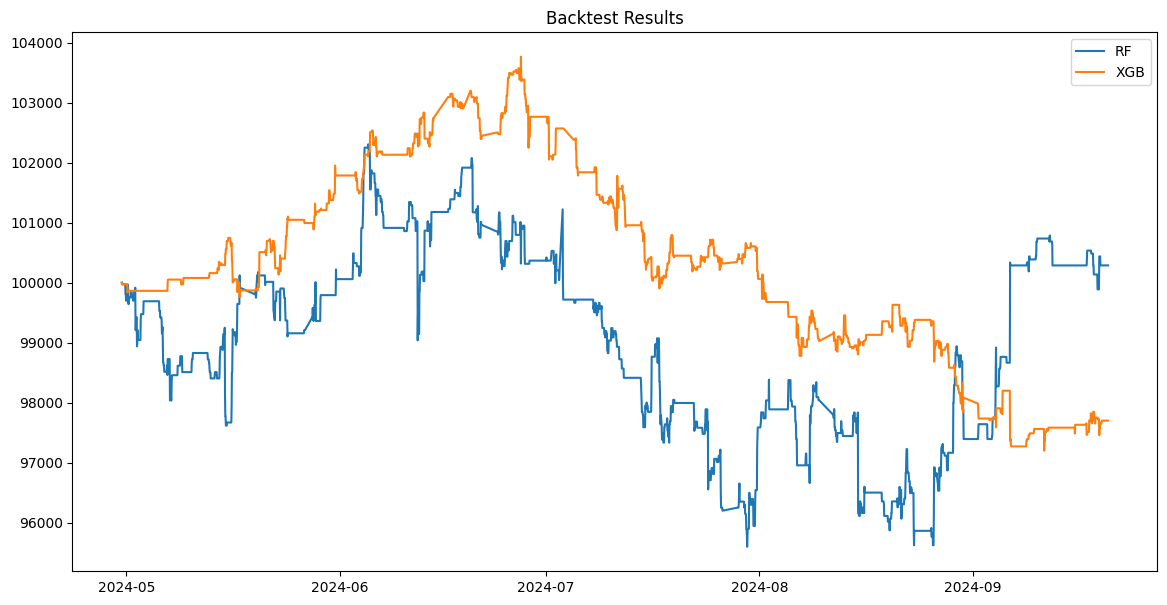

In [ ]:
# Backtesting
initial_capital = 100000
result['RF_pos'] = result['RF_sig'].shift().fillna(0).values
result['RF_val'] = initial_capital * (1 + result['RF_pos'].diff().fillna(0) * data['Close'].pct_change().fillna(0)).cumprod()
result['XGB_pos'] = result['XGB_sig'].shift().fillna(0)
result['XGB_val'] = initial_capital * (1 + result['XGB_pos'].diff().fillna(0) * data['Close'].pct_change().fillna(0)).cumprod()


# Plot results
plt.figure(figsize=(14, 7))
plt.plot(result.loc[data[-X_test.shape[0]:].index,['RF_val','XGB_val']], label=['RF','XGB'])
plt.title('Backtest Results')
plt.legend()
plt.show()

In [ ]:
result.head(19)

RF_sig  XGB_sig  LR_sig  RF_pos         RF_val  \
Datetime                                                                    
2024-04-30 08:00:00-04:00       1        1      -1     0.0  100000.000000   
2024-04-30 09:00:00-04:00       1        1      -1     1.0   99972.595232   
2024-04-30 10:00:00-04:00       1        1       1     1.0   99972.595232   
2024-04-30 11:00:00-04:00       1        1      -1     1.0   99972.595232   
2024-04-30 12:00:00-04:00       1        1      -1     1.0   99972.595232   
2024-04-30 13:00:00-04:00       1        1      -1     1.0   99972.595232   
2024-04-30 14:00:00-04:00       1        1       1     1.0   99972.595232   
2024-04-30 15:00:00-04:00       1        1      -1     1.0   99972.595232   
2024-04-30 16:00:00-04:00       1        1       1     1.0   99972.595232   
2024-04-30 18:00:00-04:00       1        1      -1     1.0   99972.595232   
2024-04-30 19:00:00-04:00       1        1      -1     1.0   99972.595232   
2024-04-30 20:00:00-04:00      -1        1      -1     1.0   99972.595232   
2024-04-30 21:00:00-04:00      -1        1      -1    -1.0   99808.166621   
2024-04-30 22:00:00-04:00       1        1      -1    -1.0   99808.166621   
2024-04-30 23:00:00-04:00       1        1      -1     1.0   99698.787808   
2024-05-01 00:00:00-04:00       1        1      -1     1.0   99698.787808   
2024-05-01 01:00:00-04:00       1        1      -1     1.0   99698.787808   
2024-05-01 02:00:00-04:00       1        1      -1     1.0   99698.787808   
2024-05-01 03:00:00-04:00      -1        2      -1     1.0   99698.787808   

                           XGB_pos        XGB_val  
Datetime                                           
2024-04-30 08:00:00-04:00      0.0  100000.000000  
2024-04-30 09:00:00-04:00      1.0   99972.595232  
2024-04-30 10:00:00-04:00      1.0   99972.595232  
2024-04-30 11:00:00-04:00      1.0   99972.595232  
2024-04-30 12:00:00-04:00      1.0   99972.595232  
2024-04-30 13:00:00-04:00      1.0   99972.595232  
2024-04-30 14:00:00-04:00      1.0   99972.595232  
2024-04-30 15:00:00-04:00      1.0   99972.595232  
2024-04-30 16:00:00-04:00      1.0   99972.595232  
2024-04-30 18:00:00-04:00      1.0   99972.595232  
2024-04-30 19:00:00-04:00      1.0   99972.595232  
2024-04-30 20:00:00-04:00      1.0   99972.595232  
2024-04-30 21:00:00-04:00      1.0   99972.595232  
2024-04-30 22:00:00-04:00      1.0   99972.595232  
2024-04-30 23:00:00-04:00      1.0   99972.595232  
2024-05-01 00:00:00-04:00      1.0   99972.595232  
2024-05-01 01:00:00-04:00      1.0   99972.595232  
2024-05-01 02:00:00-04:00      1.0   99972.595232  
2024-05-01 03:00:00-04:00      1.0   99972.595232

In [ ]:
best_model = rf #rf

<Axes: xlabel='Datetime'>

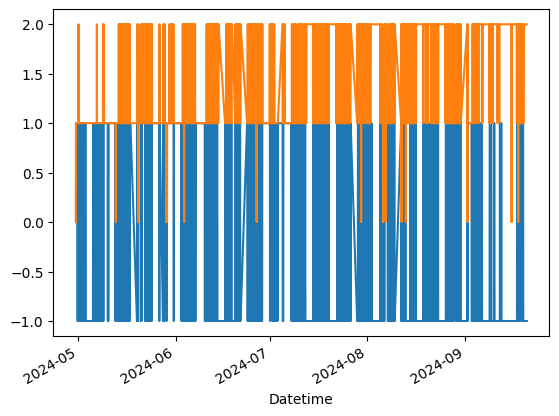

In [ ]:
result['RF_pos'].plot()
result['XGB_pos'].plot()

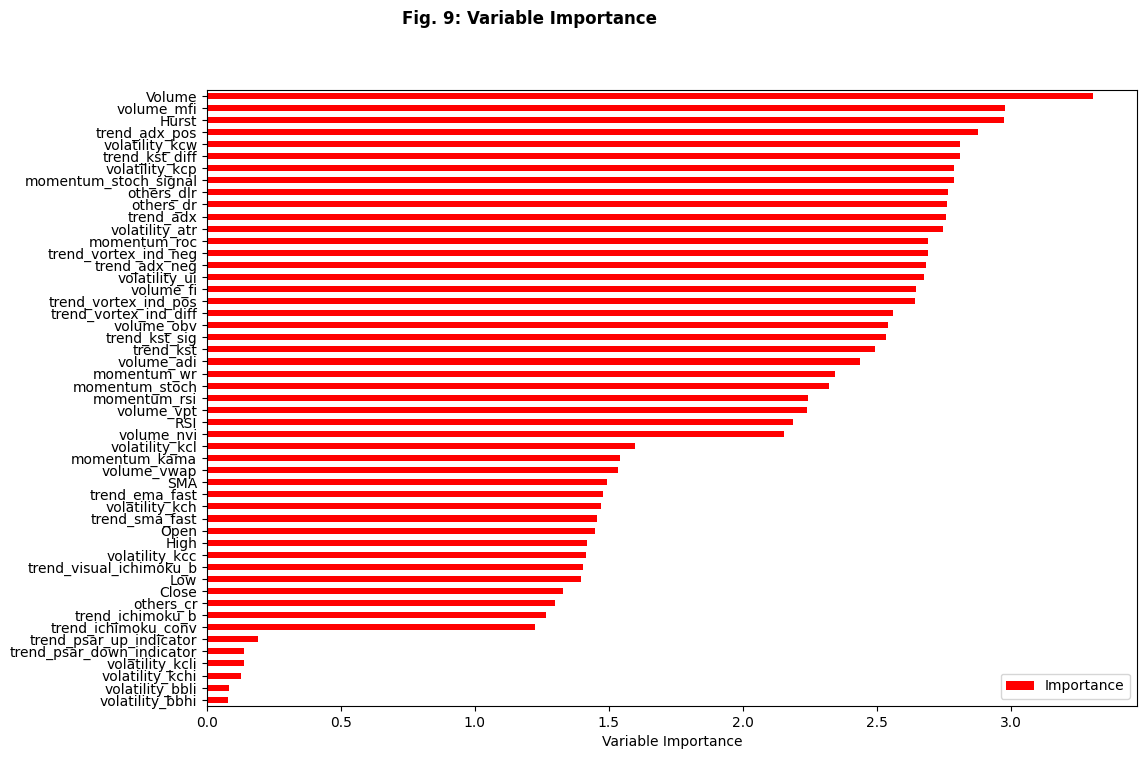

In [ ]:
# data['Position'].tail(10).plot()
Importance = pd.DataFrame(
    {"Importance": rf.feature_importances_ * 100}, index=features
)
Importance.sort_values("Importance", axis=0, ascending=True).plot(
    kind="barh", color="r", figsize=(12, 8)
)
plt.xlabel("Variable Importance")
plt.suptitle(
    "Fig. 9: Variable Importance", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [ ]:
np.sqrt(252*24)*(result['RF_pos'].diff().fillna(0) * data['Close'].pct_change().fillna(0)).dropna().mean()/(result['RF_pos'].diff().fillna(0) * data['Close'].pct_change().fillna(0)).dropna().std()

0.12458840891132136

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Hyperparameter Tuning for Random Forest
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# best_model_est = grid_search.best_estimator_
# y_pred_best = best_model_est.predict(X_test)
# print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred_best)}')


In [ ]:
# test options for classification
num_folds = 10
seed = 42
scoring = "accuracy"
metrics = {
    "balanced_accuracy": "Accuracy",
    "roc_auc": "AUC",
    "neg_log_loss": "Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision",
    "recall_weighted": "Recall",
}

In [ ]:
def run_cv(clf, X=X_train, y=y_train, metrics=metrics, cv=10, fit_params=None,
           n_jobs=-1):
    start = time()
    scores = cross_validate(
        estimator=clf,
        X=X,
        y=y,
        scoring=list(metrics.keys()),
        cv=cv,
        return_train_score=True,
        n_jobs=n_jobs,
        verbose=1,
        fit_params=fit_params,
    )
    duration = time() - start
    return scores, duration

In [ ]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split("_", 1)) for m in scores.keys()], names=["Dataset", "Metric"]
    )
    data = np.array(list(scores.values())).T
    df = pd.DataFrame(data=data, columns=columns).iloc[:, 2:]
    results = pd.melt(df, value_name="Value")
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [ ]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(
        x="Dataset",
        y="Value",
        hue="Dataset",
        col="Metric",
        data=df,
        col_order=m,
        order=["Train", "Test"],
        kind="box",
        col_wrap=3,
        sharey=False,
        height=4,
        aspect=1.2,
    )
    df = df.groupby(["Metric", "Dataset"]).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(
            0.05,
            0.85,
            s,
            fontsize=10,
            transform=ax.transAxes,
            bbox=dict(facecolor="white", edgecolor="grey", boxstyle="round,pad=0.5"),
        )
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    if fname:
        g.savefig(fname, dpi=300);

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
algo = "dummy_clf"

In [ ]:
fname = f"{algo}.joblib"

dummy_cv_result, run_time_algo = run_cv(dummy_clf)
joblib.dump(dummy_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished


['dummy_clf.joblib']

In [ ]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset         Test      Train
Metric                         
AUC              NaN        NaN
Accuracy    0.349283   0.325582
F1          0.427339   0.407389
Log Loss  -20.646273 -21.374524
Precision   0.427614   0.407887
Recall      0.427187   0.406982

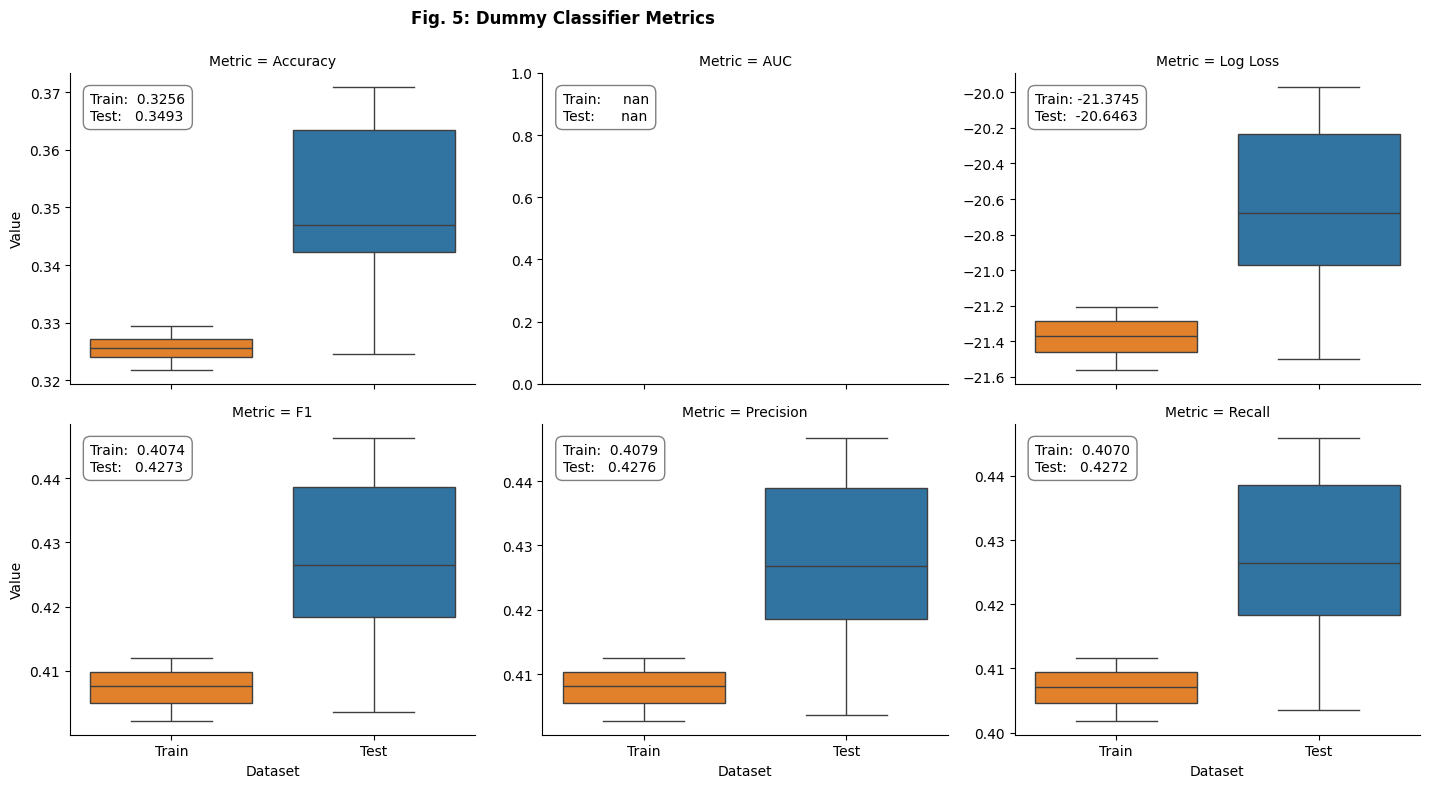

In [ ]:
plot_result(dummy_result, model="Dummy Classifier")
plt.suptitle(
    "Fig. 5: Dummy Classifier Metrics", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [ ]:
# spot check the algorithms
models = []
models.append(("LR", LogisticRegression(n_jobs=-1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# Neural Network
models.append(("NN", MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs=-1)))
models.append(("ET", ExtraTreesClassifier(n_jobs=-1)))
models.append(("Bagging", BaggingClassifier()))
# models.append(("ExtraTrees", ExtraTreesClassifier()))
# models.append(("Stacking", StackingClassifier(estimators=100, final_estimator=LogisticRegression())))
# models.append(("Voting", VotingClassifier(estimators=100)))
models.append(("XGB", XGBClassifier()))
models.append(("LightGBM", LGBMClassifier()))
models.append(("CatBoost", CatBoostClassifier(verbose=0)))
models.append(("HistGradientBoosting", HistGradientBoostingClassifier()))
# models.append(("AdaBoost", AdaBoostClassifier()))
# models.append(("GradientBoosting", GradientBoostingClassifier()))

X_train size: (9064, 51)
X_test size: (2267, 51)
y_train size: (9064,)
y_test size: (2267,)
LR: 0.478918 (0.025349)
LDA: 0.476825 (0.021650)
KNN: 0.476721 (0.025030)
CART: 0.458846 (0.025030)
NB: 0.417789 (0.042487)
NN: 0.486974 (0.025187)
AB: 0.483888 (0.016335)
GBM: 0.439516 (0.112990)
RF: 0.482125 (0.026598)
ET: 0.486426 (0.033999)
Bagging: 0.484115 (0.012563)
ExtraTrees: 0.486977 (0.022631)
XGB: 0.487308 (0.019590)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11491
[LightGBM] [Info] Number of data points in the train set: 8157, number of used features: 51
[LightGBM] [Info] Start training from score -0.735851
[LightGBM] [Info] Start training from score -2.886334
[LightGBM] [Info] Start training from score -0.765456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row

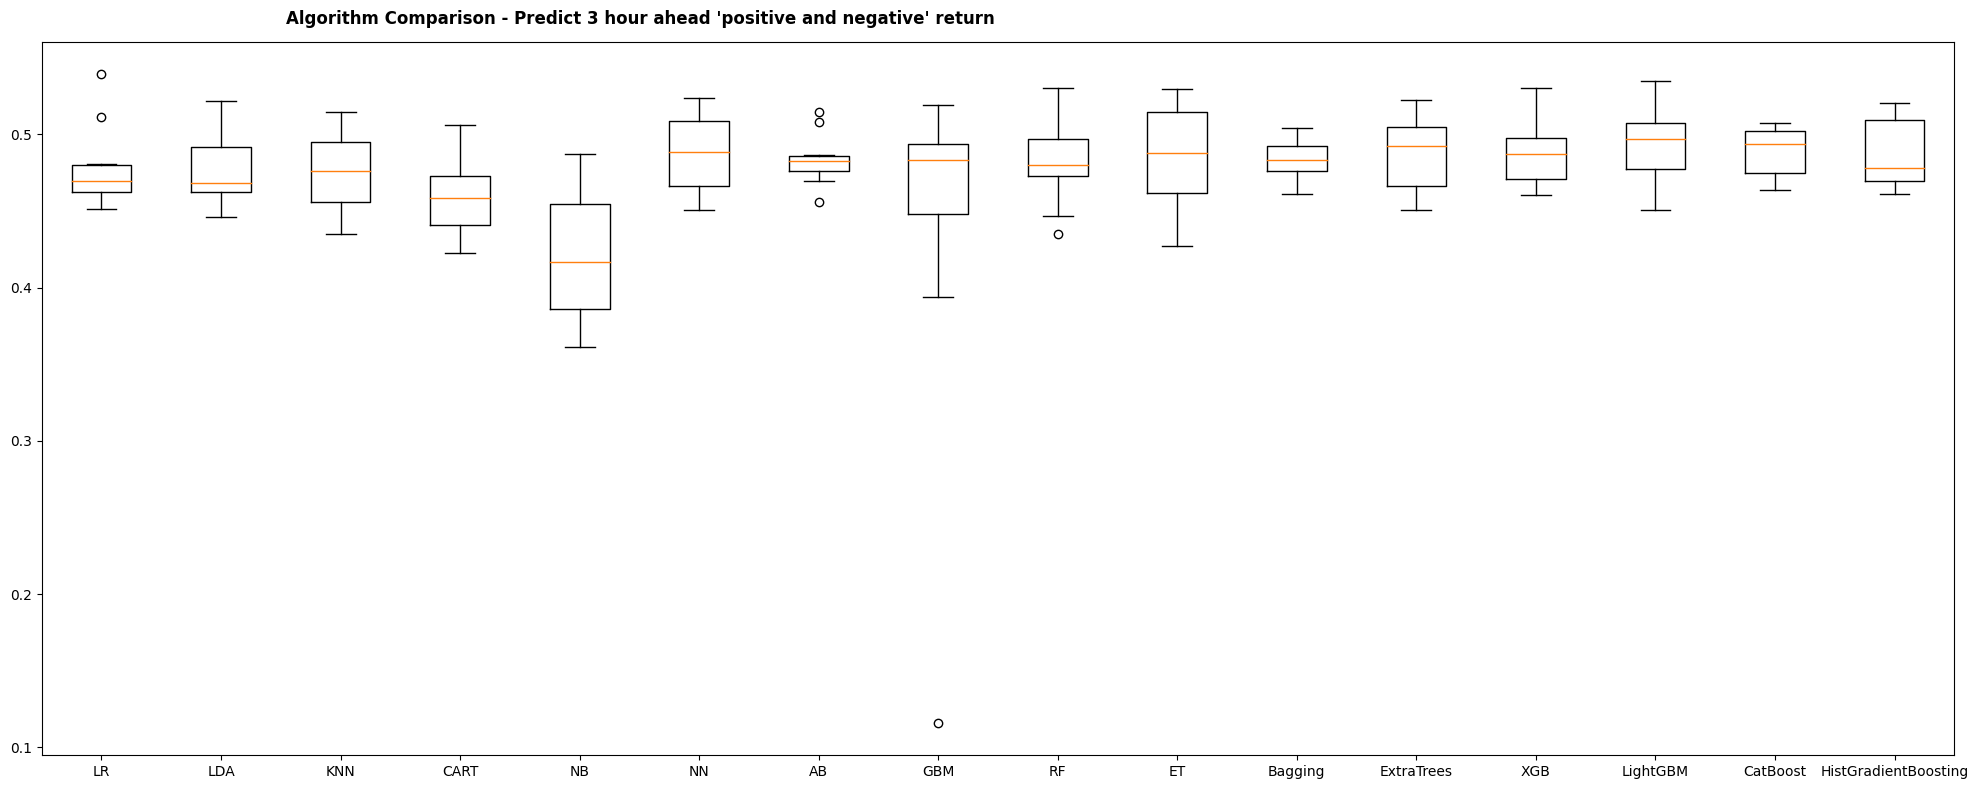

In [ ]:
h_ahead_list = [3]
for h_ahead in h_ahead_list:
    X_train, X_test, y_train, y_test, y_train_new, y_test_new = st.split_data(
        data,features,position_type='long_short',h_period=h_ahead)

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        if name == "XGB":
            cv_results = cross_val_score(model, X_train, y_train_new, cv=kfold, scoring=scoring)
        else:
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    fig.set_size_inches(20, 8)
    plt.suptitle(
        f"Algorithm Comparison - Predict {h_ahead} hour ahead 'positive and negative' return",
        fontweight="bold", horizontalalignment="right"
    )
    plt.tight_layout()
    plt.show()

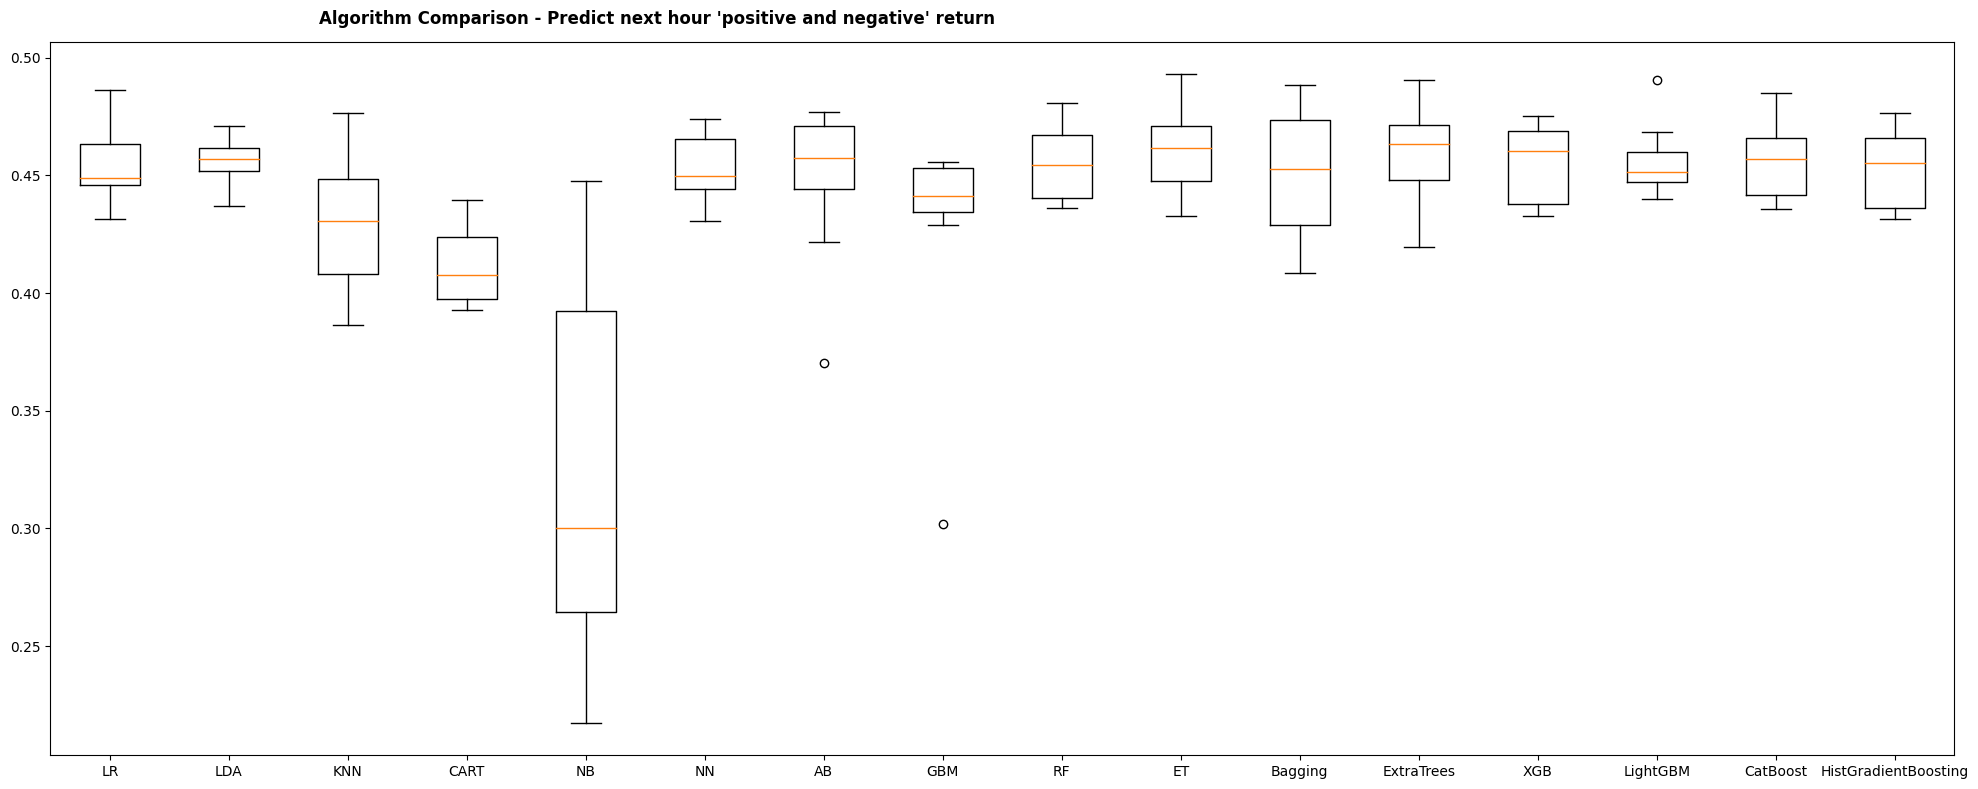

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# fig.set_size_inches(20, 8)
# plt.suptitle(
#     "Algorithm Comparison - Predict next hour 'positive and negative' return",
#     fontweight="bold", horizontalalignment="right"
# )
# plt.tight_layout()
# plt.show()

Currently - Predict one hour ahead
To do:
- Predict two hour ahead and more, to include realistic lag for implementation
- Predict daily or say session-wise ?
- Enhance with regime prediction ?


In [ ]:
h_ahead_list = [3]
for h_ahead in h_ahead_list:
    X_train, X_test, y_train, y_test, y_train_new, y_test_new = st.split_data(
        data,features,position_type='long_short',h_period=h_ahead)

In [ ]:

# Scaling the data
# scaler = StandardScaler().fit(X_train)
# rescaledX = scaler.transform(X_train)

# Define the parameter grid for Logistic Regression
C = [0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']
param_grid = dict(C=C, penalty=penalty, solver=solver)

# Define the model
model = LogisticRegression(n_jobs=-1, max_iter=10000)

# Set up the grid search
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-ad78df403994>", line 17, in <cell line: 17>
    grid_result = grid.fit(X_train, y_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 1422, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 845, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 65, in __call__
    re

TypeError: object of type 'NoneType' has no len()

In [ ]:
grid_result.best_params_

In [ ]:
# prepare model
model = LogisticRegression(solver='liblinear', penalty='l1', C=0.1)

In [ ]:
algo_forest = "logistic_regression"

In [ ]:
fname = f"{algo_forest}.joblib"

lr_cv_result, run_time_algo_forest = run_cv(model)
joblib.dump(lr_cv_result, fname)

In [ ]:
lr_result = stack_results(lr_cv_result)
lr_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

In [ ]:
plot_result(lr_result, model="Logistic regression Classifier")
plt.suptitle(
    "Fig. 7: Logistic regression Classifier Metrics",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

In [ ]:
results = {
    "Baseline": dummy_result,
    "Logistic regression": lr_result,
}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat(
        [
            df,
            result.groupby(["Metric", "Dataset"])
            .Value.mean()
            .unstack()["Test"]
            .to_frame(model),
        ],
        axis=1,
    )

df.T.sort_values("AUC", ascending=False)

In [ ]:
# model = RandomForestClassifier(
#     criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
# )
model = LogisticRegression(solver='liblinear', penalty='l1', C=0.1)
model.fit(X_train, y_train)
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
df_cm = pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=np.unique(y_test),
    index=np.unique(y_test),
)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font sizes
plt.suptitle("Fig. 8: Confusion Matrix", fontweight="bold", horizontalalignment="right")
plt.show()

In [ ]:
## Seasonality
st = Strategy()
new_data = all_data.loc['ZB=F'].copy()
new_data = new_data.dropna()
seasonality_features = st.create_seasonality_features(new_data)

# Create target variable (1 for price increase, -1 for decrease, 0 for no change)
new_data['Target'] = np.where(new_data['Close'].shift(-1) > new_data['Close'], 1,
                          np.where(new_data['Close'].shift(-1) < new_data['Close'], -1, 0))

# Drop rows with NaN values
# data.dropna(inplace=True)

# Split data into features and target
# X = seasonality_features#.drop(columns=['Target'])
# y = data['Target']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Train the model
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# # Evaluate the model
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# # Generate signals for trading
# data['Predicted_Signal'] = model.predict(seasonality_features)

In [ ]:
# new_data.head()
seasonality_features.dropna()

In [ ]:
# prompt: how to install from my github repo 'laughing bud / capstone' ?

# !pip install git+https://github.com/laughing-bud/capstone.git
#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta  # For technical analysis indicators

# Example price data (replace this with real data)
np.random.seed(42)
data = pd.DataFrame(np.random.randn(1000, 1), columns=['Close'])

# 1. Z-Score of Price from Moving Average
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['Z-Score'] = (data['Close'] - data['MA20']) / data['STD20']
data['Z-Signal'] = np.where(data['Z-Score'] < -1, 1, 0)
data['Z-Signal'] = np.where(data['Z-Score'] > 1, -1, data['Z-Signal'])

# 2. Bollinger Bands
data['BB_Upper'] = data['MA20'] + (data['STD20'] * 2)
data['BB_Lower'] = data['MA20'] - (data['STD20'] * 2)
data['BB-Signal'] = np.where(data['Close'] < data['BB_Lower'], 1, 0)
data['BB-Signal'] = np.where(data['Close'] > data['BB_Upper'], -1, data['BB-Signal'])

# 3. RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['RSI-Signal'] = np.where(data['RSI'] < 30, 1, 0)
data['RSI-Signal'] = np.where(data['RSI'] > 70, -1, data['RSI-Signal'])

# 4. MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd_diff()
data['MACD-Signal'] = np.where(data['MACD'] > 0, 1, 0)
data['MACD-Signal'] = np.where(data['MACD'] < 0, -1, data['MACD-Signal'])

# 5. Stochastic Oscillator
data['Stochastic'] = ta.momentum.StochasticOscillator(data['Close'], data['Close'], data['Close']).stoch_signal()
data['Stochastic-Signal'] = np.where(data['Stochastic'] < 20, 1, 0)
data['Stochastic-Signal'] = np.where(data['Stochastic'] > 80, -1, data['Stochastic-Signal'])

# 6. CCI
data['CCI'] = ta.trend.CCIIndicator(data['Close'], window=20).cci()
data['CCI-Signal'] = np.where(data['CCI'] < -100, 1, 0)
data['CCI-Signal'] = np.where(data['CCI'] > 100, -1, data['CCI-Signal'])

# Calculate returns for each strategy
strategies = ['Z-Signal', 'BB-Signal', 'RSI-Signal', 'MACD-Signal', 'Stochastic-Signal', 'CCI-Signal']
for strat in strategies:
    data[f'{strat}_Returns'] = data['Close'].pct_change() * data[strat].shift(1)

# Plot cumulative returns for each strategy
plt.figure(figsize=(14, 8))
for strat in strategies:
    cumulative_returns = (1 + data[f'{strat}_Returns']).cumprod()
    plt.plot(cumulative_returns, label=strat)

plt.title('Cumulative Returns of Various Mean Reversion Strategies')
plt.legend()
plt.show()


TypeError: CCIIndicator.__init__() missing 2 required positional arguments: 'low' and 'close'

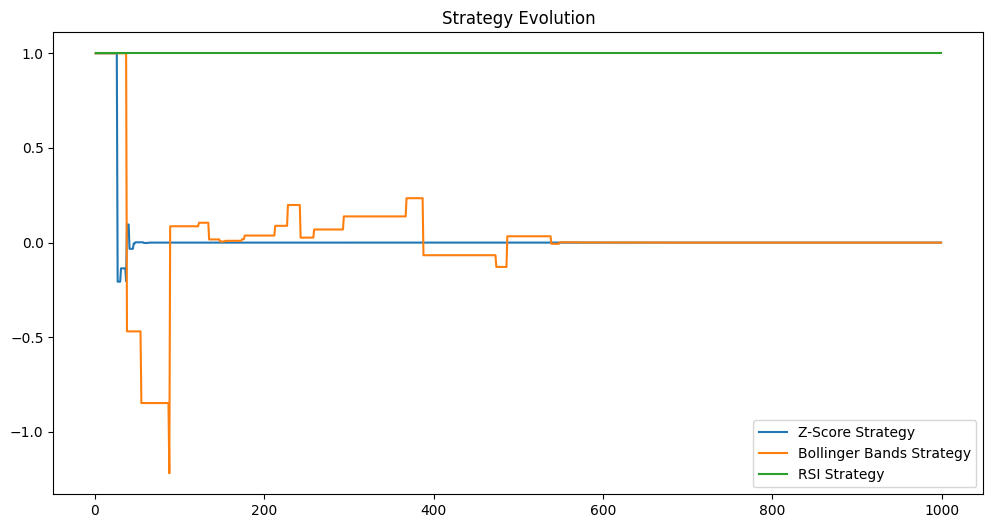

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrame
data = pd.DataFrame(np.random.randn(1000, 4), columns=['Open', 'High', 'Low', 'Close'])
data['Volume'] = np.random.randint(1000, 5000, size=(1000))

# Add technical indicators for mean-reversion signals
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['STD20'] = data['Close'].rolling(window=20).std()

# Bollinger Bands
data['Upper_BB'] = data['SMA20'] + (data['STD20'] * 2)
data['Lower_BB'] = data['SMA20'] - (data['STD20'] * 2)

# RSI calculation
def RSI(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = RSI(data['Close'])

# Generate Mean Reversion Signals
data['Signal_ZScore'] = np.where((data['Close'] - data['SMA20']) / data['STD20'] < -1, 1, 0)
data['Signal_BB'] = np.where(data['Close'] < data['Lower_BB'], 1, np.where(data['Close'] > data['Upper_BB'], -1, 0))
data['Signal_RSI'] = np.where(data['RSI'] < 30, 1, np.where(data['RSI'] > 70, -1, 0))

# Backtest: Calculate returns based on each strategy
data['Returns'] = data['Close'].pct_change()
data['Strategy_Returns_ZScore'] = data['Signal_ZScore'].shift(1) * data['Returns']
data['Strategy_Returns_BB'] = data['Signal_BB'].shift(1) * data['Returns']
data['Strategy_Returns_RSI'] = data['Signal_RSI'].shift(1) * data['Returns']

# Plot strategy evolution
plt.figure(figsize=(12, 6))
plt.plot((1 + data['Strategy_Returns_ZScore']).cumprod(), label='Z-Score Strategy')
plt.plot((1 + data['Strategy_Returns_BB']).cumprod(), label='Bollinger Bands Strategy')
plt.plot((1 + data['Strategy_Returns_RSI']).cumprod(), label='RSI Strategy')
plt.title('Strategy Evolution')
plt.legend()
plt.show()


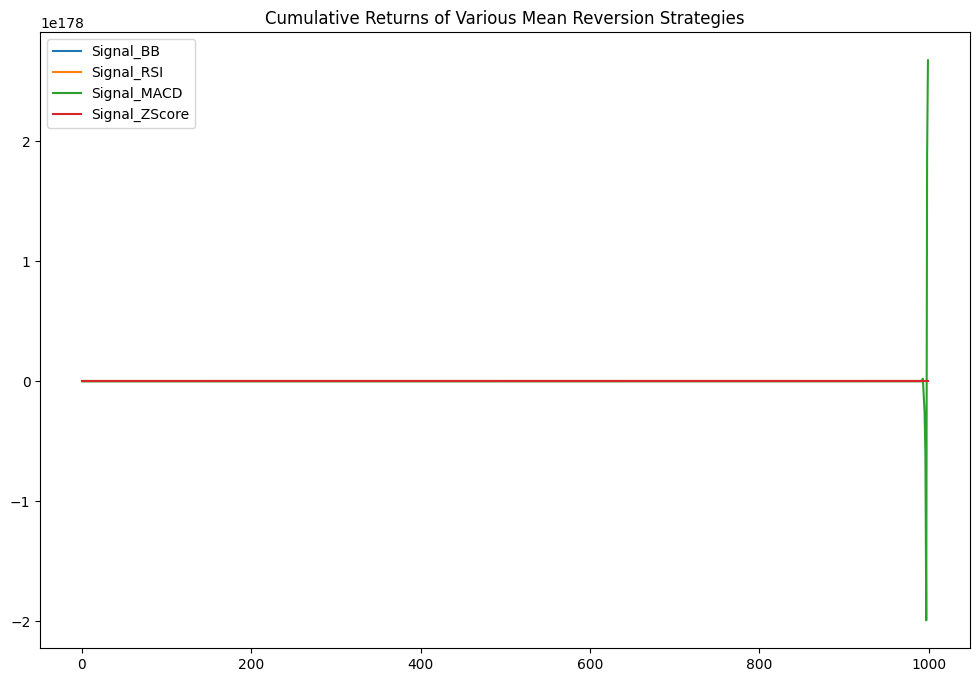

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD

# Example hourly data (replace with your actual data)
np.random.seed(42)
data = pd.DataFrame(np.random.randn(1000, 5), columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Bollinger Bands Strategy
def bollinger_strategy(data):
    bb = BollingerBands(data['Close'], window=20, window_dev=2)
    data['BB_Upper'] = bb.bollinger_hband()
    data['BB_Lower'] = bb.bollinger_lband()
    data['Signal_BB'] = np.where(data['Close'] < data['BB_Lower'], 1, np.where(data['Close'] > data['BB_Upper'], -1, 0))

# RSI Strategy
def rsi_strategy(data):
    rsi = RSIIndicator(data['Close'], window=14)
    data['RSI'] = rsi.rsi()
    data['Signal_RSI'] = np.where(data['RSI'] < 30, 1, np.where(data['RSI'] > 70, -1, 0))

# MACD Strategy
def macd_strategy(data):
    macd = MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    data['Signal_MACD'] = np.where(data['MACD'] > data['MACD_Signal'], 1, np.where(data['MACD'] < data['MACD_Signal'], -1, 0))

# Z-Score Strategy
def zscore_strategy(data):
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['STD20'] = data['Close'].rolling(window=20).std()
    data['Z-Score'] = (data['Close'] - data['MA20']) / data['STD20']
    data['Signal_ZScore'] = np.where(data['Z-Score'] < -1, 1, np.where(data['Z-Score'] > 1, -1, 0))

# Combine all strategies in a backtesting framework
def backtest_strategy(data, signal_column):
    data['Returns'] = data['Close'].pct_change()
    data['Strategy_Returns'] = data[signal_column].shift(1) * data['Returns']
    data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod()
    return data['Cumulative_Strategy_Returns']

# Apply all strategies
bollinger_strategy(data)
rsi_strategy(data)
macd_strategy(data)
zscore_strategy(data)

# Backtest each strategy
strategies = ['Signal_BB', 'Signal_RSI', 'Signal_MACD', 'Signal_ZScore']
for strategy in strategies:
    data[f'Cumulative_{strategy}'] = backtest_strategy(data, strategy)

# Plot strategy evolution
plt.figure(figsize=(12, 8))
for strategy in strategies:
    plt.plot(data[f'Cumulative_{strategy}'], label=strategy)
plt.title('Cumulative Returns of Various Mean Reversion Strategies')
plt.legend()
plt.show()


1. Bollinger Bands (Upper/Lower crossing)
2. Z-Score of the price relative to moving average
3. RSI (Relative Strength Index) below 30 (oversold)
4. Williams %R (Overbought/oversold)
5. Commodity Channel Index (CCI) crossing threshold
6. Moving Average Convergence Divergence (MACD)
7. Price crossing VWAP (Volume-Weighted Average Price)
8. Price Distance from Exponential Moving Average (EMA)
9. Price Distance from Simple Moving Average (SMA)
10. Chaikin Money Flow crossing zero
11. Price-Volume Trend (PVT)
12. Volume Spike Reversion
13. ATR Bands crossing (Average True Range)
14. Donchian Channel Reversion
15. Price Relative to Keltner Channel
16. Price crossing Ichimoku Cloud baseline
17. Money Flow Index (MFI) reversion
18. On-Balance Volume (OBV) Divergence
19. Parabolic SAR Reversion
20. Force Index Reversion
21. Stochastic Oscillator (Crossing 20/80 levels)
22. Directional Movement Index (DMI) Cross
23. Chande Momentum Oscillator (CMO) crossing thresholds
24. Intraday Volume Weighted Moving Average
25. Intraday Price Spike Reversion